# Load packages

In [6]:
import sys
import os
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler

import collections
import scrublet as scr
import scipy.io
import time

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

import logging

from rpy2.robjects import pandas2ri
import anndata2ri

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# ignore R warning messages
#rcb.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

/tmp/ipykernel_491/4258212210.py:6: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.1.0
anndata2ri                  1.3.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
cairo                       1.26.0
certifi                     2023.11.17
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
comm                        0.2.1
cupy                        12.3.0
cupy_backends               NA
cupyx                       NA
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.3
dask                        2023.11.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0

In [3]:
%%R
library(SoupX)
library(Matrix)
library(Seurat)
library(sctransform)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following object is masked from ‘package:base’:

    intersect

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [5]:
%%R
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] sctransform_0.4.1  Seurat_5.0.3       SeuratObject_5.0.1 sp_2.1-3          
[5] Matrix_1.6-5       SoupX_1.6.2       

loaded via a namespace (and not attached):
  [1] nlme_3.1-164           spatstat.sparse_3.0-3  matrixStats_1.2.0     
  [4] RcppAnnoy_0.0.22       RColorBrewer_1.1-3     httr_1.4.7       

# Filenames

In [4]:
os.chdir('/root/host_home')


In [5]:
#Filnames scanpy AnnData for lp NPC samples 23L013539 and 23L013540
adata_lp_input_1 = 'lp_NPCs/raw_data/23L013539/23L013539_filtered_feature_bc_matrix.h5'
adata_lp_input_2 = 'lp_NPCs/raw_data/23L013540/23L013540_filtered_feature_bc_matrix.h5'

#Filnames demuxlet output for lp NPC samples 23L013539 and 23L013540
demuxlet_output_1 = 'lp_NPCs/demuxlet/demuxlet_output/23L013539/23L013539.best'
demuxlet_output_2 = 'lp_NPCs/demuxlet/demuxlet_output/23L013540/23L013540.best'


In [6]:
#Filename scanpy AnnData output for lp NPC after demultiplexing
adata_out = 'lp_NPCs/processed_data/lp_NPC_filtered_cuda.h5ad'

save_dir = 'lp_NPCs/'

# Read in data

In [7]:
demux_1 = pd.read_table(demuxlet_output_1, dtype = str)
demux_2 = pd.read_table(demuxlet_output_2, dtype = str)

In [8]:
#adata_lp = sc.read(adata_out)

In [9]:
demux_1

BARCODE   RD.TOTL RD.PASS RD.UNIQ  N.SNP  \
0                        .  28514828  781567  325832  40326   
1       AAACCCAAGAAACCCG-1       126       2       2      2   
2       AAACCCAAGAAGCGAA-1       189       8       7      7   
3       AAACCCAAGAAGGACG-1        11       1       1      1   
4       AAACCCAAGAAGGATG-1     47502    1088     954    486   
...                    ...       ...     ...     ...    ...   
240735  TTTGTTGTCTTCGCTG-1         3       1       1      1   
240736  TTTGTTGTCTTCTGGC-1         3       1       1      1   
240737  TTTGTTGTCTTGGAAC-1        21       1       1      1   
240738  TTTGTTGTCTTTCCGG-1         3       2       2      2   
240739  TTTGTTGTCTTTCTAG-1         6       1       1      1   

                                                     BEST          SNG.1ST  \
0               DBL-UKERiPX7-R1-001-UKERi88H-R1-002-0.500  UKERi82A-R1-002   
1       AMB-UKERiJ2C-R1-015-UKERiM89-R1-005-UKERiJ2C-R...  UKERiJ2C-R1-015   
2       AMB-TUE3_1-UKERi82A-R1-002-TUE3_1/UKERi82A-R1-002           TUE3_1   
3       AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
4               DBL-UKERiM89-R1-005-UKERi82A-R1-002-0.500  UKERi82A-R1-002   
...                                                   ...              ...   
240735  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
240736  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
240737  AMB-UKERiJ2C-R1-015-UKERiM89-R1-005-UKERiJ2C-R...  UKERiJ2C-R1-015   
240738  AMB-UKERi1E4-R1-003-UKERiC99-R1-007-UKERiC99-R...  UKERi1E4-R1-003   
240739  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   

           SNG.LLK1          SNG.2ND     SNG.LLK2  ...          DBL.2ND  \
0       -76800.0465  UKERi88H-R1-002  -77931.0581  ...  UKERi88H-R1-002   
1           -0.0151  UKERiM89-R1-005      -0.0151  ...  UKERiM89-R1-005   
2           -2.1084  UKERi82A-R1-002      -2.7929  ...  UKERi82A-R1-002   
3           -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   
4         -429.3453  UKERiM89-R1-005    -441.0483  ...  UKERi82A-R1-002   
...             ...              ...          ...  ...              ...   
240735      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   
240736      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   
240737      -0.0075  UKERiM89-R1-005      -0.0075  ...  UKERiM89-R1-005   
240738      -0.0151  UKERiC99-R1-007      -0.7006  ...  UKERi1E4-R1-003   
240739      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   

        ALPHA        LLK12         LLK1         LLK2        LLK10  \
0       0.500  -37717.8714  -79284.0241  -77931.0581  -41178.3916   
1       0.500      -0.0151      -0.0151      -0.0151      -0.0151   
2       0.500      -2.2779      -2.1084      -2.7929      -3.0723   
3       0.500      -0.0075      -0.0075      -0.0075      -0.0075   
4       0.500    -239.7858    -441.0483    -429.3453    -357.5848   
...       ...          ...          ...          ...          ...   
240735  0.500      -0.0075      -0.0075      -0.0075      -0.0075   
240736  0.500      -0.0075      -0.0075      -0.0075      -0.0075   
240737  0.500      -0.0075      -0.0075      -0.0075      -0.0075   
240738  0.500      -0.3002      -0.7006      -0.0151      -0.5853   
240739  0.500      -0.0075      -0.0075      -0.0075      -0.0075   

              LLK20        LLK00 PRB.DBL PRB.SNG1  
0       -40552.1546  -25002.3404       1      NaN  
1           -0.0151      -0.4220   0.331    0.105  
2           -3.3571      -3.4450   0.441     0.63  
3           -0.0075      -0.0436   0.333   0.0741  
4         -371.1720    -263.7156       1        1  
...             ...          ...     ...      ...  
240735      -0.0075      -0.0810   0.333   0.0769  
240736      -0.0075      -0.1604   0.333   0.0832  
240737      -0.0075      -0.1199   0.333   0.0799  
240738      -0.3002      -1.0587    0.33    0.198  
240739      -0.0075    

In [10]:
demux_2

BARCODE   RD.TOTL RD.PASS RD.UNIQ  N.SNP  \
0                        .  27808194  769124  324252  37385   
1       AAACCCAAGAAACCCA-1        61       1       1      1   
2       AAACCCAAGAACAGGA-1         4       1       1      1   
3       AAACCCAAGAAGCGGG-1         2       1       1      1   
4       AAACCCAAGAAGGATG-1        13       1       1      1   
...                    ...       ...     ...     ...    ...   
234206  TTTGTTGTCTTAAGGC-1       127       3       3      3   
234207  TTTGTTGTCTTACACT-1         9       1       1      1   
234208  TTTGTTGTCTTACCGC-1        85       3       3      3   
234209  TTTGTTGTCTTCTCTT-1         5       1       1      1   
234210  TTTGTTGTCTTGCAGA-1         8       1       1      1   

                                                     BEST          SNG.1ST  \
0               DBL-UKERiPX7-R1-001-UKERi82A-R1-002-0.500  UKERi82A-R1-002   
1       AMB-UKERiC99-R1-007-Internal-UKERiC99-R1-007/I...  UKERiC99-R1-007   
2       AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
3       AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
4       AMB-Internal-UKERiAY6-R1-003-Internal/UKERiAY6...         Internal   
...                                                   ...              ...   
234206  AMB-UKERiJ2C-R1-015-UKERiM89-R1-005-UKERiJ2C-R...  UKERiJ2C-R1-015   
234207  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
234208  AMB-UKERiJ2C-R1-015-UKERiAY6-R1-003-UKERiJ2C-R...  UKERiJ2C-R1-015   
234209  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
234210  AMB-UKERiM89-R1-005-UKERiR66-R1-007-UKERiM89-R...  UKERiM89-R1-005   

           SNG.LLK1          SNG.2ND     SNG.LLK2  ...          DBL.2ND ALPHA  \
0       -70466.6286  UKERi88H-R1-002  -72013.1136  ...  UKERi82A-R1-002   0.5   
1           -0.0075         Internal      -0.0075  ...         Internal   0.5   
2           -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   0.5   
3           -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   0.5   
4           -0.0075  UKERiAY6-R1-003      -0.0075  ...  UKERiAY6-R1-003   0.5   
...             ...              ...          ...  ...              ...   ...   
234206      -0.0226  UKERiM89-R1-005      -0.0226  ...  UKERiM89-R1-005   0.5   
234207      -0.6931  UKERi1JF-R1-018      -0.6931  ...  UKERi1JF-R1-018   0.5   
234208      -0.7081  UKERiAY6-R1-003      -0.7081  ...  UKERiAY6-R1-003   0.5   
234209      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   0.5   
234210      -0.0075  UKERiR66-R1-007      -0.0075  ...  UKERiR66-R1-007   0.5   

              LLK12         LLK1         LLK2        LLK10        LLK20  \
0       -35209.5194  -74511.1186  -70466.6286  -38356.5934  -36983.7351   
1           -0.0075      -0.0075      -0.0075      -0.2927      -0.2927   
2           -0.0075      -0.0075      -0.0075      -0.0075      -0.0075   
3           -0.0075      -0.0075      -0.0075      -0.0075      -0.0075   
4           -0.0075      -0.0075      -0.0075      -0.6931      -0.6931   
...             ...          ...          ...          ...          ...   
234206      -0.0226      -0.0226      -0.0226      -0.0226      -0.0226   
234207      -0.6931      -0.6931      -0.6931      -0.6931      -0.6931   
234208      -0.7081      -0.7081      -0.7081      -0.7081      -0.7081   
234209      -0.0075      -0.0075      -0.0075      -0.0075      -0.0075   
234210      -0.0075      -0.0075      -0.0075      -0.6931      -0.6931   

              LLK00 PRB.DBL PRB.SNG1  
0       -23164.3682       1   #NAME?  
1           -0.7784   0.333    0.154  
2            -0.081   0.333   0.0769  
3           -0.5016   0.333    0.117  
4            -0.766   0.333    0.153  
...             ...     ...      ...  
234206       -0.827   0.309    0.129  
234207      -2.5521   0.333    0.458  
234208       -1.608   0.348    0.196  
234209      -0.0436   0.333   0.0741  
234210      -0.2927   

In [11]:
adata_lp_1 = sc.read_10x_h5(filename=adata_lp_input_1)
adata_lp_1 = adata_lp_1[~adata_lp_1.obs.index.str.contains('TGTAAGCAGGTTGACG-1')]
adata_lp_2 = sc.read_10x_h5(filename=adata_lp_input_2)

reading lp_NPCs/raw_data/23L013539/23L013539_filtered_feature_bc_matrix.h5
 (0:00:04)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading lp_NPCs/raw_data/23L013540/23L013540_filtered_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:04)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata_lp_1.var['gene_symbols'] = adata_lp_1.var_names
adata_lp_2.var['gene_symbols'] = adata_lp_2.var_names

/tmp/ipykernel_98213/296776479.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_lp_1.var['gene_symbols'] = adata_lp_1.var_names
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
adata_lp_1.var_names_make_unique()
adata_lp_2.var_names_make_unique()

In [13]:
adata_lp_1

AnnData object with n_obs × n_vars = 20757 × 20682
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [14]:
print('Datasets containing all barcodes')
print('dataset 1',';', 'lane 23L013539\n')
adata_lp_1
print('\ndataset 2',';', 'lane 23L013540\n')
adata_lp_2

Datasets containing all barcodes
dataset 1 ; lane 23L013539



AnnData object with n_obs × n_vars = 20757 × 20682
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'


dataset 2 ; lane 23L013540



AnnData object with n_obs × n_vars = 20380 × 20682
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [15]:
adata_lp_1.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGAAGGATG-1, AAACCCAAGAATACAC-1, AAACCCAAGACTCTAC-1, AAACCCAAGATCACCT-1, AAACCCAAGGGACTGT-1, AAACCCACAAAGGCGT-1, AAACCCACAATAGAGT-1, AAACCCACAGGTTACT-1, AAACCCACATCGATAC-1, AAACCCAGTAATGCGG-1, AAACCCAGTACGACAG-1, AAACCCAGTAGCCAGA-1, AAACCCAGTCCAGCAC-1, AAACCCAGTCCTGGGT-1, AAACCCAGTCTAACTG-1, AAACCCAGTCTTGTCC-1, AAACCCAGTTACGCCG-1, AAACCCATCAATCAGC-1, AAACCCATCGCACGGT-1, AAACCCATCTAACACG-1, AAACCCATCTCTATAC-1, AAACGAAAGCCTGCCA-1, AAACGAAAGTTACGAA-1, AAACGAACAAGACAAT-1, AAACGAACAAGATGGC-1, AAACGAACAATCAGCT-1, AAACGAACAGACACAG-1, AAACGAACAGGCGTTC-1, AAACGAACATACATCG-1, AAACGAACATGGAACG-1, AAACGAAGTGCACATT-1, AAACGAAGTGGACTGA-1, AAACGAAGTGTCTTGA-1, AAACGAAGTTCAAAGA-1, AAACGAAGTTCCAAAC-1, AAACGAAGTTGCATTG-1, AAACGAATCCGTATGA-1, AAACGAATCCGTGTAA-1, AAACGAATCCGTTGGG-1, AAACGAATCGGCCAAC-1, AAACGCTAGACTGGGT-1, AAACGCTAGGTAAGGA-1, AAACGCTAGGTCTTTG-1, AAACGCTAGTAAGCAT-1, AAACGCTAGTCGTTAC-1, AAACGCTCATCTAGAC-1, AAACGCTGTACAGTCT-1, AAACGCTGTACTGTTG-1, AAACGCTGTCGATTAC-1, AAACGCTGTCGTTCAA-1, AAACGCTGTGACTAAA-1, AAACGCTGTGGTTTAC-1, AAACGCTGTGTCTTAG-1, AAACGCTGTTGCTAGT-1, AAACGCTGTTGGGCCT-1, AAACGCTTCATTGGTG-1, AAACGCTTCATTTGTC-1, AAACGCTTCTGCCCTA-1, AAAGAACAGATGGCGT-1, AAAGAACAGGAGAGGC-1, AAAGAACAGGAGCAAA-1, AAAGAACAGGCACTAG-1, AAAGAACAGGCTCCCA-1, AAAGAACAGGTTGCCC-1, AAAGAACAGTCAGAGC-1, AAAGAACCAAGTGACG-1, AAAGAACCACCAGCGT-1, AAAGAACCACGCGCAT-1, AAAGAACCACGTATAC-1, AAAGAACCACTAGAGG-1, AAAGAACCATAACAGA-1, AAAGAACCATGTCAGT-1, AAAGAACGTACTAAGA-1, AAAGAACGTATGAGCG-1, AAAGAACGTCTTCATT-1, AAAGAACGTGTTAAAG-1, AAAGAACGTTAGAGAT-1, AAAGAACTCCATGAGT-1, AAAGAACTCCTTATAC-1, AAAGAACTCGTGGAAG-1, AAAGAACTCTAGTTCT-1, AAAGAACTCTGAACGT-1, AAAGGATAGACCTCCG-1, AAAGGATAGTAGAGTT-1, AAAGGATCACGCGCAT-1, AAAGGATCAGCGACCT-1, AAAGGATGTCCTTAAG-1, AAAGGATGTCTAACGT-1, AAAGGATGTCTGTCAA-1, AAAGGATGTGGTCCCA-1, AAAGGATGTTTGTTCT-1, AAAGGATTCATCGCCT-1, AAAGGATTCCCTCGAT-1, AAAGGATTCCCTCTTT-1, AAAGGATTCTCCTGAC-1, AAAGGGCAGCCAAGCA-1, AAAGGGCAGGCCTTGC-1, AAAGGGCAGTTGGAGC-1, AAAGGGCCAAACAGGC-1, AAAGGGCCAAGACTGG-1, ...]

[20757 rows x 0 columns]

In [16]:
demux_1

BARCODE   RD.TOTL RD.PASS RD.UNIQ  N.SNP  \
0                        .  28514828  781567  325832  40326   
1       AAACCCAAGAAACCCG-1       126       2       2      2   
2       AAACCCAAGAAGCGAA-1       189       8       7      7   
3       AAACCCAAGAAGGACG-1        11       1       1      1   
4       AAACCCAAGAAGGATG-1     47502    1088     954    486   
...                    ...       ...     ...     ...    ...   
240735  TTTGTTGTCTTCGCTG-1         3       1       1      1   
240736  TTTGTTGTCTTCTGGC-1         3       1       1      1   
240737  TTTGTTGTCTTGGAAC-1        21       1       1      1   
240738  TTTGTTGTCTTTCCGG-1         3       2       2      2   
240739  TTTGTTGTCTTTCTAG-1         6       1       1      1   

                                                     BEST          SNG.1ST  \
0               DBL-UKERiPX7-R1-001-UKERi88H-R1-002-0.500  UKERi82A-R1-002   
1       AMB-UKERiJ2C-R1-015-UKERiM89-R1-005-UKERiJ2C-R...  UKERiJ2C-R1-015   
2       AMB-TUE3_1-UKERi82A-R1-002-TUE3_1/UKERi82A-R1-002           TUE3_1   
3       AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
4               DBL-UKERiM89-R1-005-UKERi82A-R1-002-0.500  UKERi82A-R1-002   
...                                                   ...              ...   
240735  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
240736  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
240737  AMB-UKERiJ2C-R1-015-UKERiM89-R1-005-UKERiJ2C-R...  UKERiJ2C-R1-015   
240738  AMB-UKERi1E4-R1-003-UKERiC99-R1-007-UKERiC99-R...  UKERi1E4-R1-003   
240739  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   

           SNG.LLK1          SNG.2ND     SNG.LLK2  ...          DBL.2ND  \
0       -76800.0465  UKERi88H-R1-002  -77931.0581  ...  UKERi88H-R1-002   
1           -0.0151  UKERiM89-R1-005      -0.0151  ...  UKERiM89-R1-005   
2           -2.1084  UKERi82A-R1-002      -2.7929  ...  UKERi82A-R1-002   
3           -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   
4         -429.3453  UKERiM89-R1-005    -441.0483  ...  UKERi82A-R1-002   
...             ...              ...          ...  ...              ...   
240735      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   
240736      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   
240737      -0.0075  UKERiM89-R1-005      -0.0075  ...  UKERiM89-R1-005   
240738      -0.0151  UKERiC99-R1-007      -0.7006  ...  UKERi1E4-R1-003   
240739      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   

        ALPHA        LLK12         LLK1         LLK2        LLK10  \
0       0.500  -37717.8714  -79284.0241  -77931.0581  -41178.3916   
1       0.500      -0.0151      -0.0151      -0.0151      -0.0151   
2       0.500      -2.2779      -2.1084      -2.7929      -3.0723   
3       0.500      -0.0075      -0.0075      -0.0075      -0.0075   
4       0.500    -239.7858    -441.0483    -429.3453    -357.5848   
...       ...          ...          ...          ...          ...   
240735  0.500      -0.0075      -0.0075      -0.0075      -0.0075   
240736  0.500      -0.0075      -0.0075      -0.0075      -0.0075   
240737  0.500      -0.0075      -0.0075      -0.0075      -0.0075   
240738  0.500      -0.3002      -0.7006      -0.0151      -0.5853   
240739  0.500      -0.0075      -0.0075      -0.0075      -0.0075   

              LLK20        LLK00 PRB.DBL PRB.SNG1  
0       -40552.1546  -25002.3404       1      NaN  
1           -0.0151      -0.4220   0.331    0.105  
2           -3.3571      -3.4450   0.441     0.63  
3           -0.0075      -0.0436   0.333   0.0741  
4         -371.1720    -263.7156       1        1  
...             ...          ...     ...      ...  
240735      -0.0075      -0.0810   0.333   0.0769  
240736      -0.0075      -0.1604   0.333   0.0832  
240737      -0.0075      -0.1199   0.333   0.0799  
240738      -0.3002      -1.0587    0.33    0.198  
240739      -0.0075    

In [17]:
adata_lp_2.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGACTTCGT-1, AAACCCAAGAGCTGCA-1, AAACCCAAGCAGTAAT-1, AAACCCAAGCGTCGAA-1, AAACCCAAGGGAGGTG-1, AAACCCAAGTACTGTC-1, AAACCCAAGTAGAGTT-1, AAACCCAAGTGCGACA-1, AAACCCACATGCCGCA-1, AAACCCAGTAGCACGA-1, AAACCCAGTCGAACAG-1, AAACCCAGTTACACAC-1, AAACCCATCAACTGAC-1, AAACCCATCCAAGGGA-1, AAACCCATCGTGCACG-1, AAACCCATCTTGGTGA-1, AAACGAAAGAAGGATG-1, AAACGAAAGAATTGCA-1, AAACGAAAGAGTGGCT-1, AAACGAAAGCGTTCCG-1, AAACGAAAGTAAGAGG-1, AAACGAACAAAGAGTT-1, AAACGAACAAATGATG-1, AAACGAACAGCTATTG-1, AAACGAAGTAGCTTTG-1, AAACGAAGTATCGAGG-1, AAACGAAGTGAAAGTT-1, AAACGAATCTCATTTG-1, AAACGAATCTTACCGC-1, AAACGCTAGAGCAGCT-1, AAACGCTAGAGCGACT-1, AAACGCTAGCACTTTG-1, AAACGCTAGGGCCAAT-1, AAACGCTAGGTCACTT-1, AAACGCTCAAATGATG-1, AAACGCTCAATCGCGC-1, AAACGCTCAATCTCTT-1, AAACGCTCAATTGAGA-1, AAACGCTCACGGATCC-1, AAACGCTCAGCTACCG-1, AAACGCTCATCCTAAG-1, AAACGCTGTAATCAAG-1, AAACGCTGTGACATCT-1, AAACGCTGTTAACCTG-1, AAACGCTTCATCACCC-1, AAACGCTTCCTTATCA-1, AAACGCTTCGACTCCT-1, AAACGCTTCGCATTGA-1, AAACGCTTCTACCACC-1, AAAGAACAGAGTAACT-1, AAAGAACAGCGACTAG-1, AAAGAACAGCGCCGTT-1, AAAGAACAGTCACTGT-1, AAAGAACCACTTGAGT-1, AAAGAACCAGAGGTAC-1, AAAGAACCATGACTTG-1, AAAGAACGTAGATCGG-1, AAAGAACGTCACGACC-1, AAAGAACGTTAGAAAC-1, AAAGAACGTTATAGAG-1, AAAGAACGTTGTTTGG-1, AAAGAACTCAAACCCA-1, AAAGAACTCACGAACT-1, AAAGAACTCAGGGATG-1, AAAGAACTCTAGTACG-1, AAAGAACTCTGGGTCG-1, AAAGAACTCTTCTCAA-1, AAAGGATAGAATTCAG-1, AAAGGATAGGAGAGGC-1, AAAGGATAGGATTTCC-1, AAAGGATCAAGGTCTT-1, AAAGGATCACACTGGC-1, AAAGGATCACTCCCTA-1, AAAGGATCAGGCATTT-1, AAAGGATCATCAGCGC-1, AAAGGATGTCAAATCC-1, AAAGGATGTCAGGAGT-1, AAAGGATGTCCTGGTG-1, AAAGGATGTGATTAGA-1, AAAGGATGTGCCTGAC-1, AAAGGATGTGGCTAGA-1, AAAGGATGTGGCTCTG-1, AAAGGATGTGTCCTAA-1, AAAGGATGTGTGCCTG-1, AAAGGATTCCCATGGG-1, AAAGGATTCCGAGATT-1, AAAGGATTCCTCCACA-1, AAAGGATTCCTGATAG-1, AAAGGATTCCTTTAGT-1, AAAGGATTCGAGCTGC-1, AAAGGATTCGGATAAA-1, AAAGGATTCTCCTGTG-1, AAAGGGCAGGCATGCA-1, AAAGGGCAGGGCTAAC-1, AAAGGGCAGTTTGAGA-1, AAAGGGCCAACTCATG-1, AAAGGGCCAAGAATAC-1, AAAGGGCCACAGCTTA-1, AAAGGGCCACCCAACG-1, AAAGGGCCAGAACTCT-1, ...]

[20380 rows x 0 columns]

In [18]:
demux_2

BARCODE   RD.TOTL RD.PASS RD.UNIQ  N.SNP  \
0                        .  27808194  769124  324252  37385   
1       AAACCCAAGAAACCCA-1        61       1       1      1   
2       AAACCCAAGAACAGGA-1         4       1       1      1   
3       AAACCCAAGAAGCGGG-1         2       1       1      1   
4       AAACCCAAGAAGGATG-1        13       1       1      1   
...                    ...       ...     ...     ...    ...   
234206  TTTGTTGTCTTAAGGC-1       127       3       3      3   
234207  TTTGTTGTCTTACACT-1         9       1       1      1   
234208  TTTGTTGTCTTACCGC-1        85       3       3      3   
234209  TTTGTTGTCTTCTCTT-1         5       1       1      1   
234210  TTTGTTGTCTTGCAGA-1         8       1       1      1   

                                                     BEST          SNG.1ST  \
0               DBL-UKERiPX7-R1-001-UKERi82A-R1-002-0.500  UKERi82A-R1-002   
1       AMB-UKERiC99-R1-007-Internal-UKERiC99-R1-007/I...  UKERiC99-R1-007   
2       AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
3       AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
4       AMB-Internal-UKERiAY6-R1-003-Internal/UKERiAY6...         Internal   
...                                                   ...              ...   
234206  AMB-UKERiJ2C-R1-015-UKERiM89-R1-005-UKERiJ2C-R...  UKERiJ2C-R1-015   
234207  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
234208  AMB-UKERiJ2C-R1-015-UKERiAY6-R1-003-UKERiJ2C-R...  UKERiJ2C-R1-015   
234209  AMB-UKERiJ2C-R1-015-UKERi1JF-R1-018-UKERiJ2C-R...  UKERiJ2C-R1-015   
234210  AMB-UKERiM89-R1-005-UKERiR66-R1-007-UKERiM89-R...  UKERiM89-R1-005   

           SNG.LLK1          SNG.2ND     SNG.LLK2  ...          DBL.2ND ALPHA  \
0       -70466.6286  UKERi88H-R1-002  -72013.1136  ...  UKERi82A-R1-002   0.5   
1           -0.0075         Internal      -0.0075  ...         Internal   0.5   
2           -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   0.5   
3           -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   0.5   
4           -0.0075  UKERiAY6-R1-003      -0.0075  ...  UKERiAY6-R1-003   0.5   
...             ...              ...          ...  ...              ...   ...   
234206      -0.0226  UKERiM89-R1-005      -0.0226  ...  UKERiM89-R1-005   0.5   
234207      -0.6931  UKERi1JF-R1-018      -0.6931  ...  UKERi1JF-R1-018   0.5   
234208      -0.7081  UKERiAY6-R1-003      -0.7081  ...  UKERiAY6-R1-003   0.5   
234209      -0.0075  UKERi1JF-R1-018      -0.0075  ...  UKERi1JF-R1-018   0.5   
234210      -0.0075  UKERiR66-R1-007      -0.0075  ...  UKERiR66-R1-007   0.5   

              LLK12         LLK1         LLK2        LLK10        LLK20  \
0       -35209.5194  -74511.1186  -70466.6286  -38356.5934  -36983.7351   
1           -0.0075      -0.0075      -0.0075      -0.2927      -0.2927   
2           -0.0075      -0.0075      -0.0075      -0.0075      -0.0075   
3           -0.0075      -0.0075      -0.0075      -0.0075      -0.0075   
4           -0.0075      -0.0075      -0.0075      -0.6931      -0.6931   
...             ...          ...          ...          ...          ...   
234206      -0.0226      -0.0226      -0.0226      -0.0226      -0.0226   
234207      -0.6931      -0.6931      -0.6931      -0.6931      -0.6931   
234208      -0.7081      -0.7081      -0.7081      -0.7081      -0.7081   
234209      -0.0075      -0.0075      -0.0075      -0.0075      -0.0075   
234210      -0.0075      -0.0075      -0.0075      -0.6931      -0.6931   

              LLK00 PRB.DBL PRB.SNG1  
0       -23164.3682       1   #NAME?  
1           -0.7784   0.333    0.154  
2            -0.081   0.333   0.0769  
3           -0.5016   0.333    0.117  
4            -0.766   0.333    0.153  
...             ...     ...      ...  
234206       -0.827   0.309    0.129  
234207      -2.5521   0.333    0.458  
234208       -1.608   0.348    0.196  
234209      -0.0436   0.333   0.0741  
234210      -0.2927   

# Add Donor information from demuxlet

In [19]:
#dataset _1
#filter demuxlet output list for Barcods present in the adata object and being called as AMB, DBL, and SNG
demux_1['Demux_state'] = np.select([demux_1['BEST'].str.contains('AMB'), demux_1['BEST'].str.contains('DBL'), demux_1['BEST'].str.contains('SNG')],
                                   ['AMB', 'DBL', 'SNG'])
demux_1.rename(columns={'SNG.1ST':'Donor'}, inplace = True)
demux_1 = demux_1[['BARCODE', 'Donor', 'Demux_state']]
demux_1 = demux_1.loc[demux_1['BARCODE'].isin(adata_lp_1.obs.index)]

#filter adata object for AMB, DBL, and SNG
adata_lp_1 = adata_lp_1[adata_lp_1.obs.index.isin(demux_1['BARCODE'])]

#Add Demuxlet state as obs either 'AMB', 'DBL', 'SNG'
adata_lp_1.obs['Demux_state'] = pd.Categorical(demux_1['Demux_state'])

#Add Donor info obtained from demuxlet to obs
adata_lp_1.obs['Donor'] = pd.Categorical(demux_1['Donor'])

/tmp/ipykernel_98213/1642319706.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_lp_1.obs['Demux_state'] = pd.Categorical(demux_1['Demux_state'])


In [20]:
#dataset _2
#filter demuxlet output list for Barcods present in the adata object and being called as AMB, DBL, and SNG
demux_2['Demux_state'] = np.select([demux_2['BEST'].str.contains('AMB'), demux_2['BEST'].str.contains('DBL'), demux_2['BEST'].str.contains('SNG')],
                                   ['AMB', 'DBL', 'SNG'])
demux_2.rename(columns={'SNG.1ST':'Donor'}, inplace = True)
demux_2 = demux_2[['BARCODE', 'Donor', 'Demux_state']]
demux_2 = demux_2.loc[demux_2['BARCODE'].isin(adata_lp_2.obs.index)]
#filter adata object for AMB, DBL, and SNG
adata_lp_2 = adata_lp_2[adata_lp_2.obs.index.isin(demux_2['BARCODE'])]

#Add Demuxlet state as obs either 'AMB', 'DBL', 'SNG'
adata_lp_2.obs['Demux_state'] = pd.Categorical(demux_2['Demux_state'])

#Add Donor info obtained from demuxlet to obs
adata_lp_2.obs['Donor'] = pd.Categorical(demux_2['Donor'])

/tmp/ipykernel_98213/2804982225.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_lp_2.obs['Demux_state'] = pd.Categorical(demux_2['Demux_state'])


In [21]:
print('Datasets containing only "AMB", "DBL", "SNG"\n')
print('dataset 1',';', 'lane 23L013539\n')
adata_lp_1
print('\ndataset 2',';', 'lane 23L013540\n')
adata_lp_2

Datasets containing only "AMB", "DBL", "SNG"

dataset 1 ; lane 23L013539



AnnData object with n_obs × n_vars = 20757 × 20682
    obs: 'Demux_state', 'Donor'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'


dataset 2 ; lane 23L013540



AnnData object with n_obs × n_vars = 20380 × 20682
    obs: 'Demux_state', 'Donor'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [22]:
adata_lp_1.obs_names = adata_lp_1.obs_names.str.split('-').str[0].astype('str')
adata_lp_2.obs_names = adata_lp_2.obs_names.str.split('-').str[0].astype('str')

In [23]:
#Concatenate adata objects
adata_lp = adata_lp_1.concatenate(adata_lp_2, batch_key = 'lane', batch_categories = ['23L013539', '23L013540'])
adata_lp
adata_lp.obs

/tmp/ipykernel_98213/3929187384.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_lp = adata_lp_1.concatenate(adata_lp_2, batch_key = 'lane', batch_categories = ['23L013539', '23L013540'])


AnnData object with n_obs × n_vars = 41137 × 20682
    obs: 'Demux_state', 'Donor', 'lane'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

Demux_state            Donor       lane
AAACCCAAGAAGGATG-23L013539         DBL  UKERi82A-R1-002  23L013539
AAACCCAAGAATACAC-23L013539         SNG  UKERiG3G-R1-039  23L013539
AAACCCAAGACTCTAC-23L013539         SNG  UKERiC99-R1-007  23L013539
AAACCCAAGATCACCT-23L013539         SNG  UKERiG3G-R1-039  23L013539
AAACCCAAGGGACTGT-23L013539         SNG  UKERiC99-R1-007  23L013539
...                                ...              ...        ...
TTTGTTGGTTCGAACT-23L013540         SNG  UKERiPX7-R1-001  23L013540
TTTGTTGGTTCGATTG-23L013540         DBL  UKERiPX7-R1-001  23L013540
TTTGTTGGTTCTCAGA-23L013540         SNG  UKERiPX7-R1-001  23L013540
TTTGTTGTCGGTCGGT-23L013540         SNG  UKERiPX7-R1-001  23L013540
TTTGTTGTCGTTCTGC-23L013540         SNG  UKERiG3G-R1-039  23L013540

[41137 rows x 3 columns]

In [24]:
Ctrl = ['UKERi1JF-R1-018', 'UKERiG3G-R1-039', 'UKERi1E4-R1-003', 'UKERiO3H-R1-005', 'UKERi82A-R1-002']
sPD = ['UKERiJ2C-R1-015', 'UKERiM89-R1-005', 'UKERiC99-R1-007', 'UKERiR66-R1-007', 'UKERiAY6-R1-003', 'UKERiPX7-R1-001', 'UKERi88H-R1-002']
alld = Ctrl + sPD

In [25]:
#Add condition (either 'Control' or 'Parkinson') to obs
adata_lp.obs['condition'] = np.where(adata_lp.obs['Donor'].isin(Ctrl), 'Control', 'Parkinson')

#Add age of biopsy to obs
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi1JF-R1-018'), 'age'] = 42
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiG3G-R1-039'), 'age'] = 69
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi1E4-R1-003'), 'age'] = 53
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiO3H-R1-005'), 'age'] = 71
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi82A-R1-002'), 'age'] = 66

adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'age'] = 73
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiM89-R1-005'), 'age'] = 64
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiC99-R1-007'), 'age'] = 68
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiR66-R1-007'), 'age'] = 54
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiAY6-R1-003'), 'age'] = 37
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiPX7-R1-001'), 'age'] = 49
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi88H-R1-002'), 'age'] = 63

#Add years of illness at biopsy to obs
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'years_of_illness'] = 3
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiM89-R1-005'), 'years_of_illness'] = 3
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiC99-R1-007'), 'years_of_illness'] = 7
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiR66-R1-007'), 'years_of_illness'] = 3
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiAY6-R1-003'), 'years_of_illness'] = 4
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiPX7-R1-001'), 'years_of_illness'] = 1
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi88H-R1-002'), 'years_of_illness'] = 6

#Add disease progression rates
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaHY'] = 3
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaHY'] = 3
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaHY'] = 2.5

adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaHY'] = 1
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaHY'] = 1
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaHY'] = 2

adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaUPDRS'] = 24
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaUPDRS'] = 53
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaUPDRS'] = 36

adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaUPDRS'] = -1
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaUPDRS'] = 0
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaUPDRS'] = 7

adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaADL'] = -0.6
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaADL'] = -0.6
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaADL'] = -0.5

adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaADL'] = -0.2
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaADL'] = -0.1
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaADL'] = -0.3

#Add increase in required L-Dopa medication 
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaDOPA'] = 400
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaDOPA'] = 1563
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaDOPA'] = 610

adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaDOPA'] = 800
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaDOPA'] = 1900
adata_lp.obs.loc[(adata_lp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaDOPA'] = 640


#Add Donor gender (either 'M' or 'F') to obs
female = ['UKERi88H-R1-002', 'UKERiG3G-R1-039', 'UKERi82A-R1-002']
adata_lp.obs['gender'] = np.where(adata_lp.obs['Donor'].isin(female), 'F', 'M')

#Add cultivation period (either 'lp' or 'hp') to obs
adata_lp.obs['cultivation_period'] = 'lp'

#Only keep sPD Donor cells in list
adata_lp = adata_lp[adata_lp.obs['Donor'].isin(alld)]

In [26]:
adata_lp
adata_lp.obs
adata_lp.var

View of AnnData object with n_obs × n_vars = 41102 × 20682
    obs: 'Demux_state', 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

Demux_state            Donor       lane  condition  \
AAACCCAAGAAGGATG-23L013539         DBL  UKERi82A-R1-002  23L013539    Control   
AAACCCAAGAATACAC-23L013539         SNG  UKERiG3G-R1-039  23L013539    Control   
AAACCCAAGACTCTAC-23L013539         SNG  UKERiC99-R1-007  23L013539  Parkinson   
AAACCCAAGATCACCT-23L013539         SNG  UKERiG3G-R1-039  23L013539    Control   
AAACCCAAGGGACTGT-23L013539         SNG  UKERiC99-R1-007  23L013539  Parkinson   
...                                ...              ...        ...        ...   
TTTGTTGGTTCGAACT-23L013540         SNG  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGGTTCGATTG-23L013540         DBL  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGGTTCTCAGA-23L013540         SNG  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGTCGGTCGGT-23L013540         SNG  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGTCGTTCTGC-23L013540         SNG  UKERiG3G-R1-039  23L013540    Control   

                             age  years_of_illness  deltaHY  deltaUPDRS  \
AAACCCAAGAAGGATG-23L013539  66.0               NaN      NaN         NaN   
AAACCCAAGAATACAC-23L013539  69.0               NaN      NaN         NaN   
AAACCCAAGACTCTAC-23L013539  68.0               7.0      2.5        36.0   
AAACCCAAGATCACCT-23L013539  69.0               NaN      NaN         NaN   
AAACCCAAGGGACTGT-23L013539  68.0               7.0      2.5        36.0   
...                          ...               ...      ...         ...   
TTTGTTGGTTCGAACT-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGGTTCGATTG-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGGTTCTCAGA-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGTCGGTCGGT-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGTCGTTCTGC-23L013540  69.0               NaN      NaN         NaN   

                            deltaADL  deltaDOPA gender cultivation_period  
AAACCCAAGAAGGATG-23L013539       NaN        NaN      F                 lp  
AAACCCAAGAATACAC-23L013539       NaN        NaN      F                 lp  
AAACCCAAGACTCTAC-23L013539      -0.5      610.0      M                 lp  
AAACCCAAGATCACCT-23L013539       NaN        NaN      F                 lp  
AAACCCAAGGGACTGT-23L013539      -0.5      610.0      M                 lp  
...                              ...        ...    ...                ...  
TTTGTTGGTTCGAACT-23L013540      -0.1     1900.0      M                 lp  
TTTGTTGGTTCGATTG-23L013540      -0.1     1900.0      M                 lp  
TTTGTTGGTTCTCAGA-23L013540      -0.1     1900.0      M                 lp  
TTTGTTGTCGGTCGGT-23L013540      -0.1     1900.0      M                 lp  
TTTGTTGTCGTTCTGC-23L013540       NaN        NaN      F                 lp  

[41102 rows x 12 columns]

gene_ids    feature_types  \
ATAD3B           ENSG00000160072  Gene Expression   
PRDM16           ENSG00000142611  Gene Expression   
PEX10            ENSG00000157911  Gene Expression   
PEX14            ENSG00000142655  Gene Expression   
PLCH2            ENSG00000149527  Gene Expression   
...                          ...              ...   
ENSG00000275063  ENSG00000275063  Gene Expression   
ENSG00000277856  ENSG00000277856  Gene Expression   
ENSG00000271254  ENSG00000271254  Gene Expression   
ENSG00000268674  ENSG00000268674  Gene Expression   
ENSG00000277475  ENSG00000277475  Gene Expression   

                                                         genome  \
ATAD3B           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PRDM16           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX10            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX14            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PLCH2            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
...                                                         ...   
ENSG00000275063  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000277856  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000271254  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000268674  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000277475  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   

                    gene_symbols  
ATAD3B                    ATAD3B  
PRDM16                    PRDM16  
PEX10                      PEX10  
PEX14                      PEX14  
PLCH2                      PLCH2  
...                          ...  
ENSG00000275063  ENSG00000275063  
ENSG00000277856  ENSG00000277856  
ENSG00000271254  ENSG00000271254  
ENSG00000268674  ENSG00000268674  
ENSG00000277475  ENSG00000277475  

[20682 rows x 4 columns]

In [27]:
del demux_1
del demux_2
del adata_lp_1
del adata_lp_2

# Check metadata

In [28]:
#Check dataset stats
adata_lp
adata_lp.obs['lane'].value_counts()
adata_lp.obs['Demux_state'].value_counts()
adata_lp.obs['Donor'].value_counts()


View of AnnData object with n_obs × n_vars = 41102 × 20682
    obs: 'Demux_state', 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

lane
23L013539    20738
23L013540    20364
Name: count, dtype: int64

Demux_state
SNG    33978
DBL     6985
AMB      139
Name: count, dtype: int64

Donor
UKERiPX7-R1-001    6830
UKERiO3H-R1-005    4235
UKERi88H-R1-002    4019
UKERiAY6-R1-003    3478
UKERi82A-R1-002    3443
UKERi1E4-R1-003    3159
UKERiR66-R1-007    3047
UKERiM89-R1-005    2910
UKERiG3G-R1-039    2809
UKERiC99-R1-007    2796
UKERiJ2C-R1-015    2287
UKERi1JF-R1-018    2089
Name: count, dtype: int64

In [29]:
adata_lp.obs.condition.value_counts()
adata_lp.obs.age.value_counts()
adata_lp.obs.years_of_illness.value_counts()
adata_lp.obs.gender.value_counts()

condition
Parkinson    25367
Control      15735
Name: count, dtype: int64

age
49.0    6830
71.0    4235
63.0    4019
37.0    3478
66.0    3443
53.0    3159
54.0    3047
64.0    2910
69.0    2809
68.0    2796
73.0    2287
42.0    2089
Name: count, dtype: int64

years_of_illness
3.0    8244
1.0    6830
6.0    4019
4.0    3478
7.0    2796
Name: count, dtype: int64

gender
M    30831
F    10271
Name: count, dtype: int64

# Visualize DBLs and AMBs called by demuxlet

In [30]:
# Quality control - calculate QC covariates

# mitochondrial genes
adata_lp.var['mt'] = adata_lp.var.gene_symbols.str.startswith('MT-')
# ribosomal genes
adata_lp.var['ribo'] = adata_lp.var.gene_symbols.str.startswith(('RPS', 'RPL'))
# hemoglobin genes.
adata_lp.var['hb'] = adata_lp.var.gene_symbols.str.contains(('^HB[^(P)]'))

sc.pp.calculate_qc_metrics(
    adata_lp, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=[20], log1p=True
)
adata_lp

/tmp/ipykernel_98213/2668170509.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_lp.var['mt'] = adata_lp.var.gene_symbols.str.startswith('MT-')


AnnData object with n_obs × n_vars = 41102 × 20682
    obs: 'Demux_state', 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [31]:
if not os.path.exists(save_dir+'figures'):
    # Create a new directory because it does not exist
    os.mkdir(save_dir+'figures')
    print("The new directory: "+save_dir+"figures is created!")
else: 
    print("The directory "+save_dir+"figures already exists")

The directory lp_NPCs/figures already exists


In [32]:
if not os.path.exists(save_dir+'figures/QC'):
    # Create a new directory because it does not exist
    os.mkdir(save_dir+'figures/QC')
    print("The new directory: "+save_dir+"figures/QC is created!")
else: 
    print("The directory "+save_dir+"figures/QC already exists")

The directory lp_NPCs/figures/QC already exists


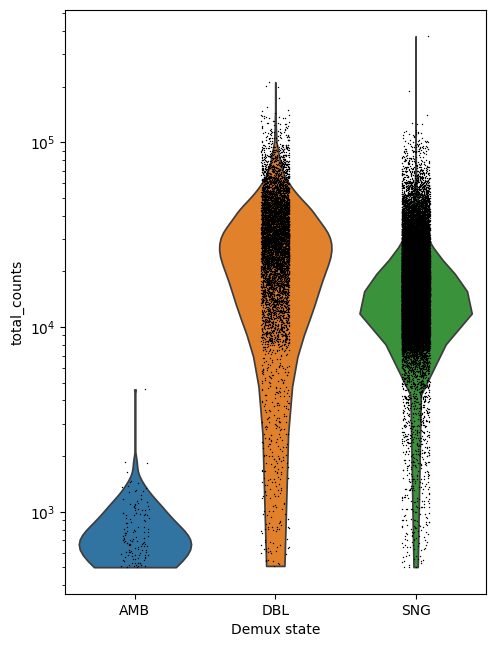

In [33]:
plt.rcParams['figure.figsize']=(5.3,8) #rescale figures
t1 = sc.pl.violin(adata_lp, 'total_counts', groupby='Demux_state', log=True, cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Demux_state_violin_total_counts.svg')

# Quality Control - filtering counts, genes, mt fraction

## Visualize stats for combined dataset

In [34]:
# Quality control - calculate QC covariates

# mitochondrial genes
adata_lp.var['mt'] = adata_lp.var.gene_symbols.str.startswith('MT-')
# ribosomal genes
adata_lp.var['ribo'] = adata_lp.var.gene_symbols.str.startswith(('RPS', 'RPL'))
# hemoglobin genes.
adata_lp.var['hb'] = adata_lp.var.gene_symbols.str.contains(('^HB[^(P)]'))

sc.pp.calculate_qc_metrics(
    adata_lp, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=[20], log1p=True
)
adata_lp

AnnData object with n_obs × n_vars = 41102 × 20682
    obs: 'Demux_state', 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'Demux_state_colors'

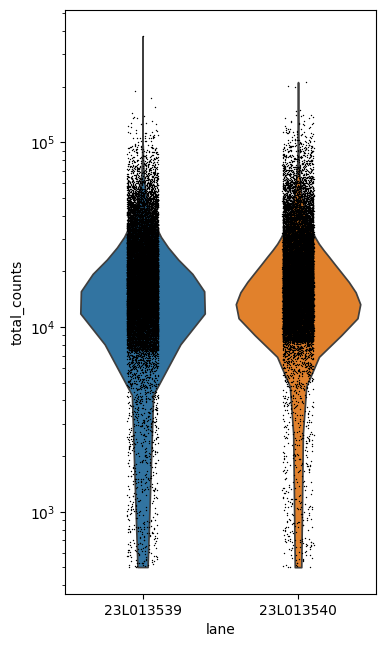

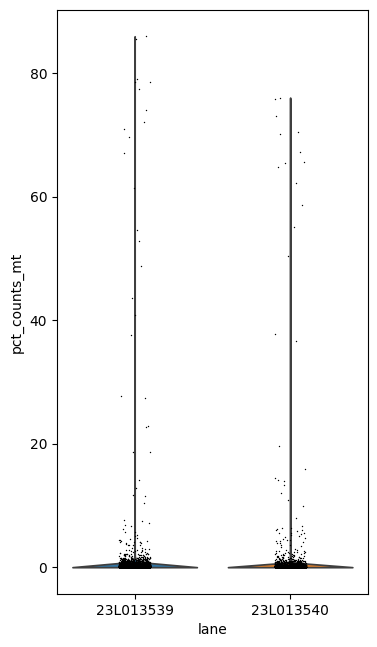

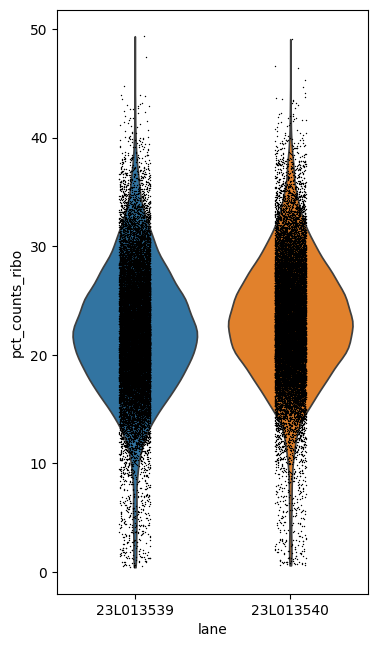

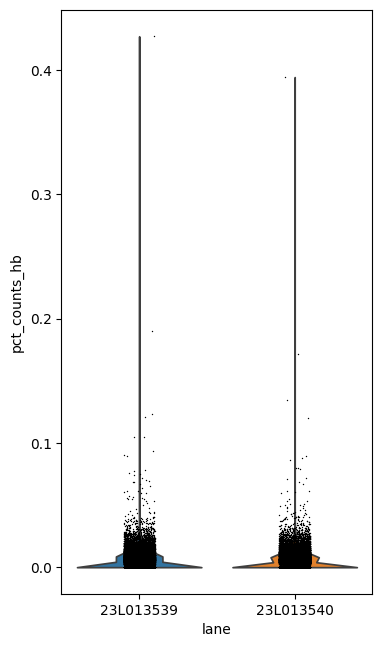

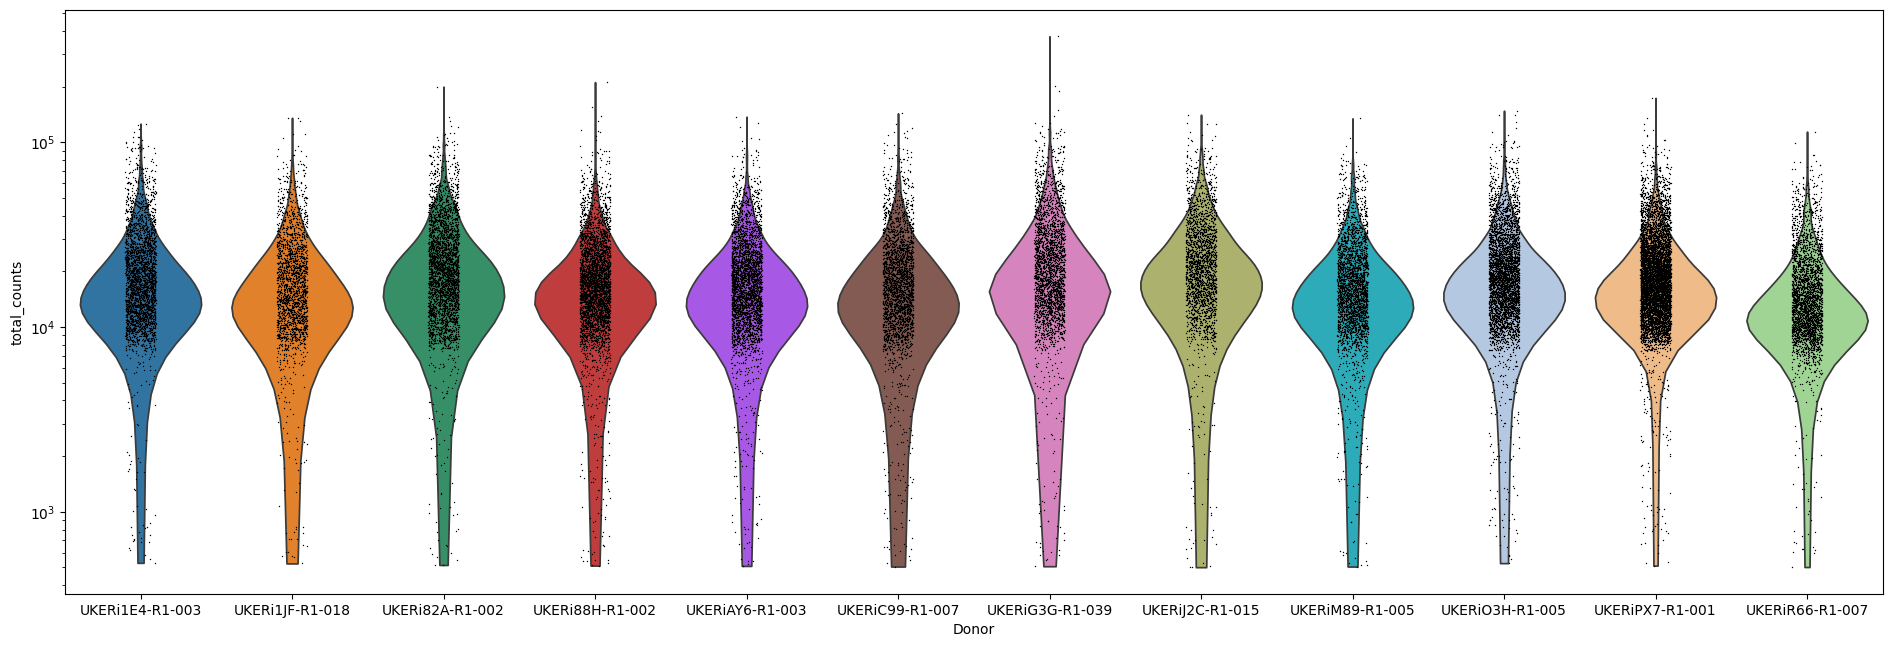

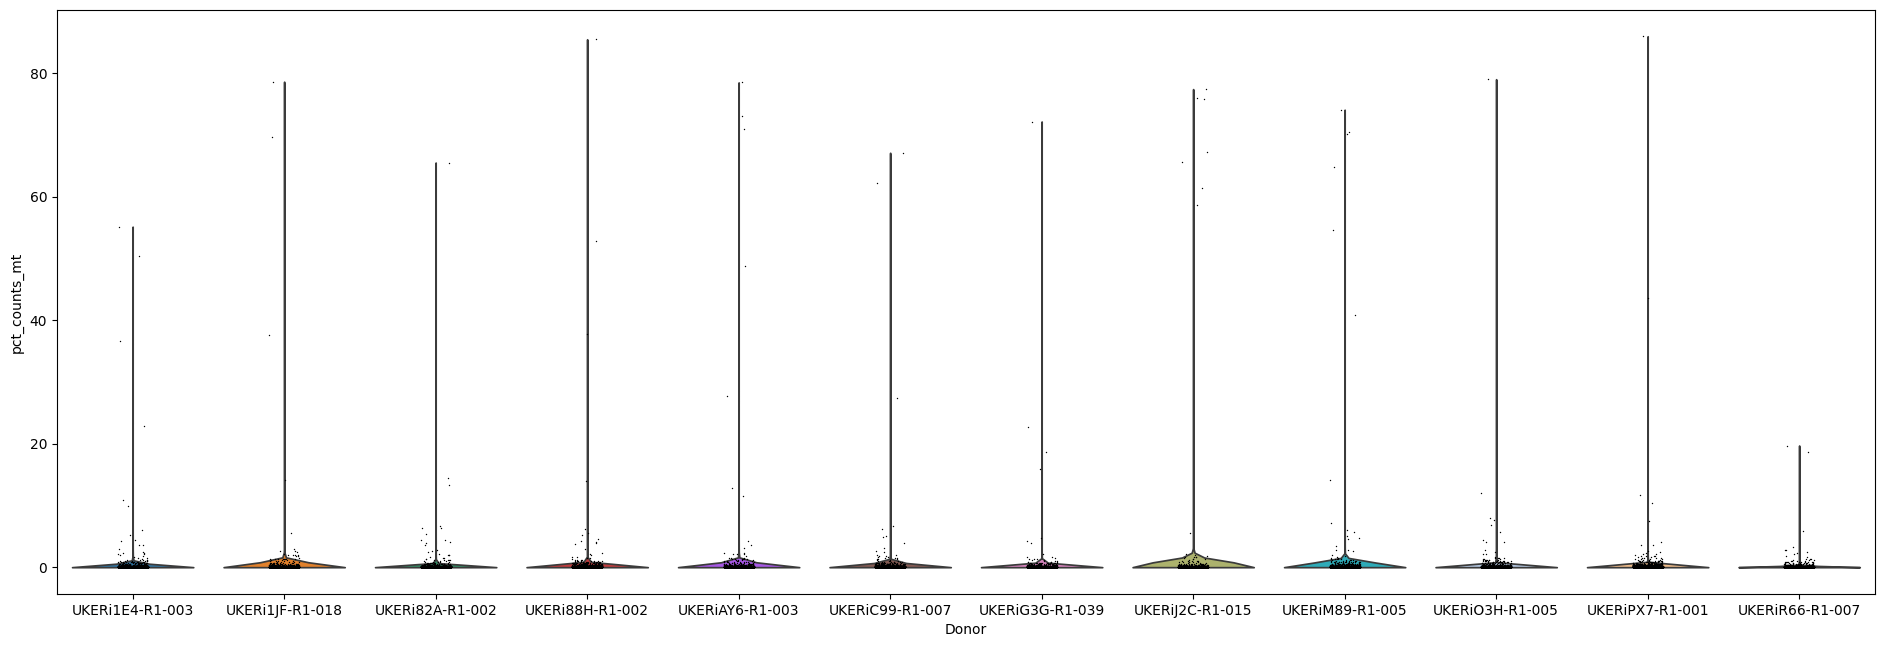

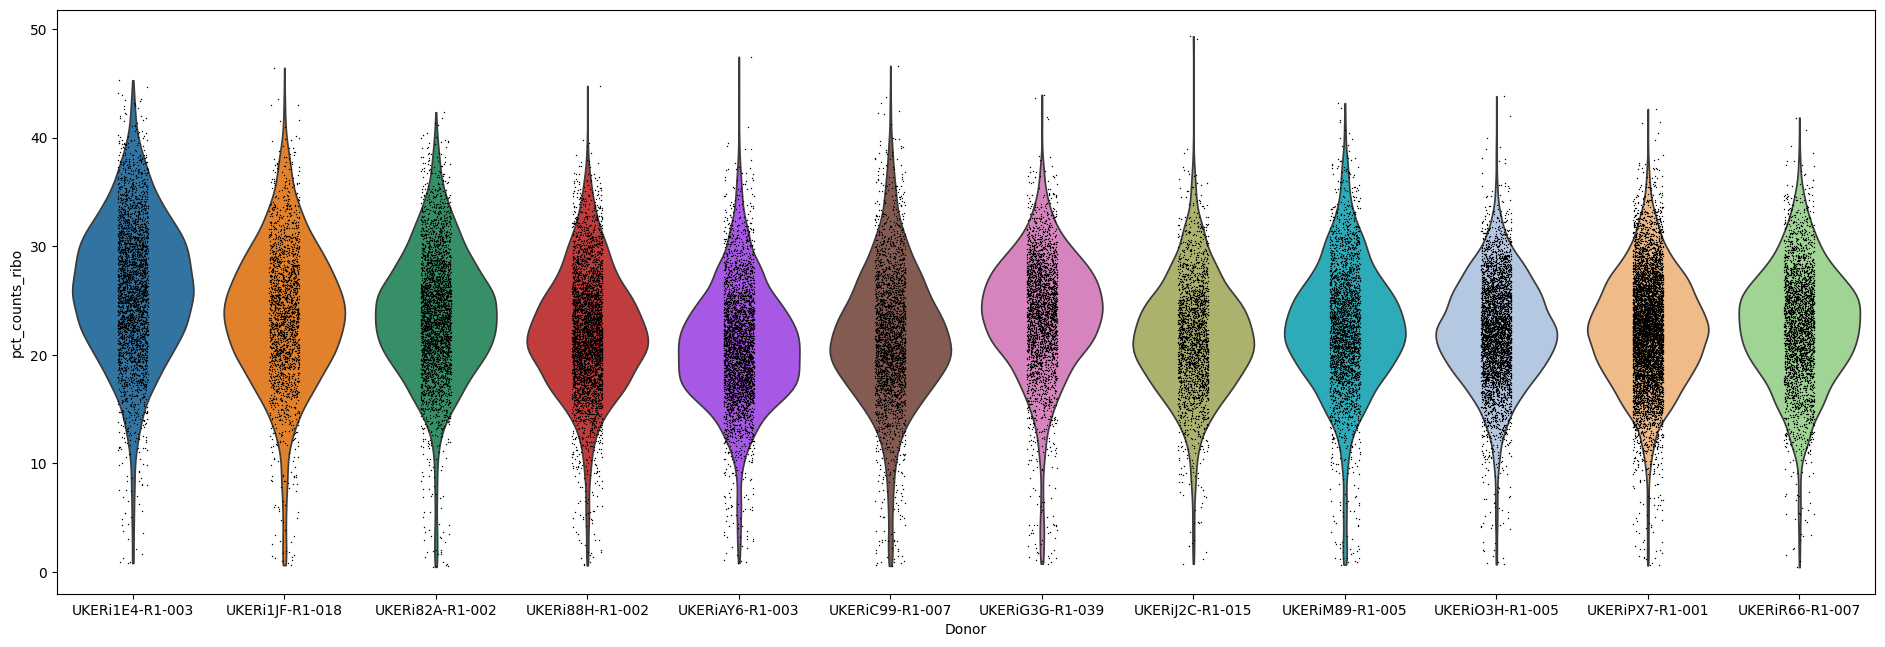

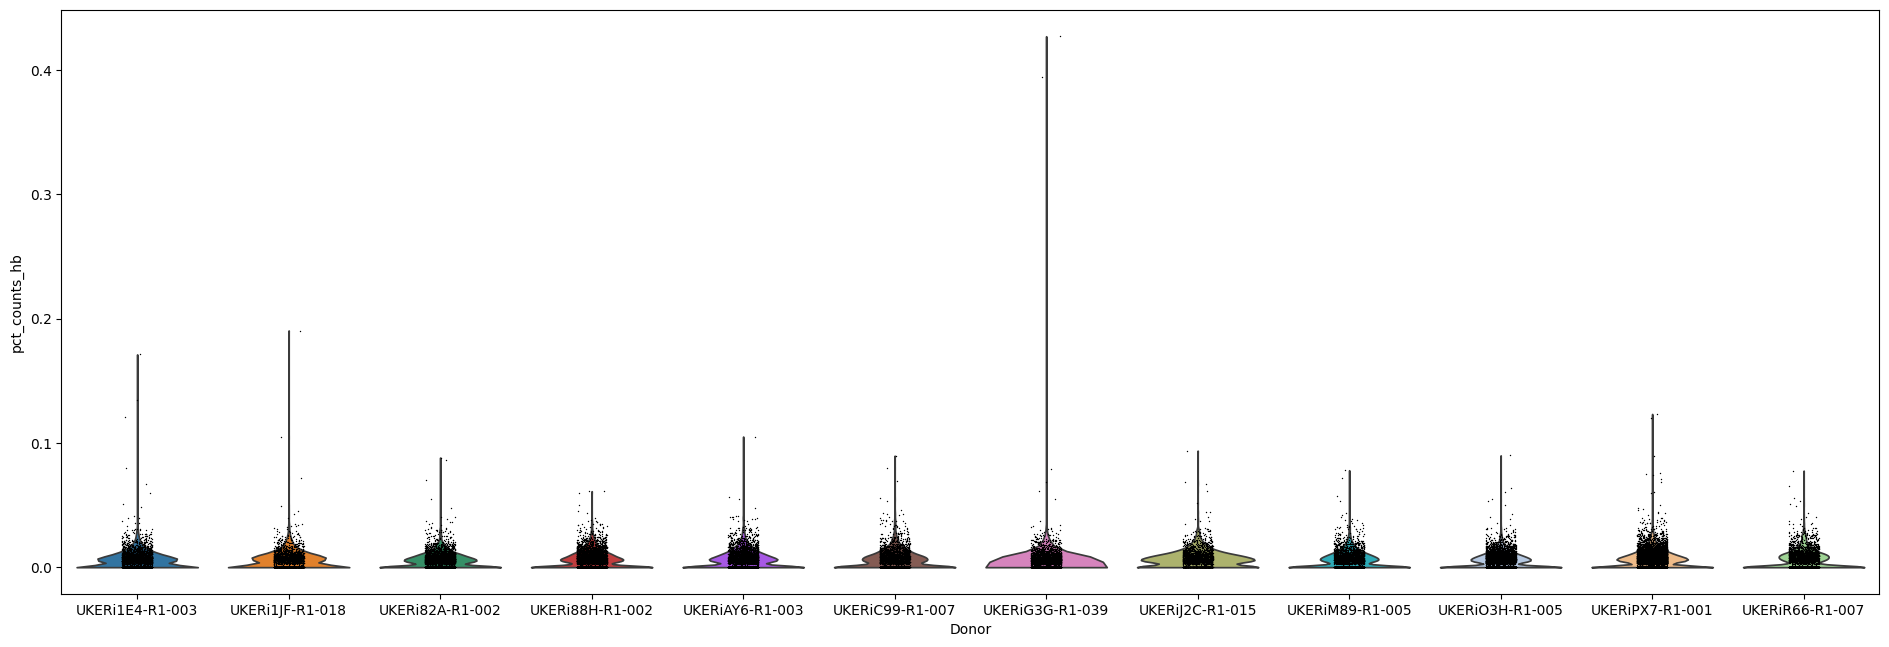

In [35]:
#Sample quality plots
plt.rcParams['figure.figsize']=(4.3,8) #rescale figures
t1 = sc.pl.violin(adata_lp, 'total_counts', groupby='lane', log=True, cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_total_counts.svg')

plt.rcParams['figure.figsize']=(4.3,8) #rescale figures
t2 = sc.pl.violin(adata_lp, 'pct_counts_mt', groupby='lane', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata_lp, 'pct_counts_ribo', groupby='lane', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata_lp, 'pct_counts_hb', groupby='lane', show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_pct_counts_hb.svg')

plt.rcParams['figure.figsize']=(18,8) #rescale figures
t5 = sc.pl.violin(adata_lp, 'total_counts', groupby='Donor', log=True, cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_total_counts.svg')
t6 = sc.pl.violin(adata_lp, 'pct_counts_mt', groupby='Donor', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata_lp, 'pct_counts_ribo', groupby='Donor', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata_lp, 'pct_counts_hb', groupby='Donor', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_pct_counts_hb.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

Data are consistent across lanes, and broadly across Donors. Nevertheless, filtering was performed per sample.

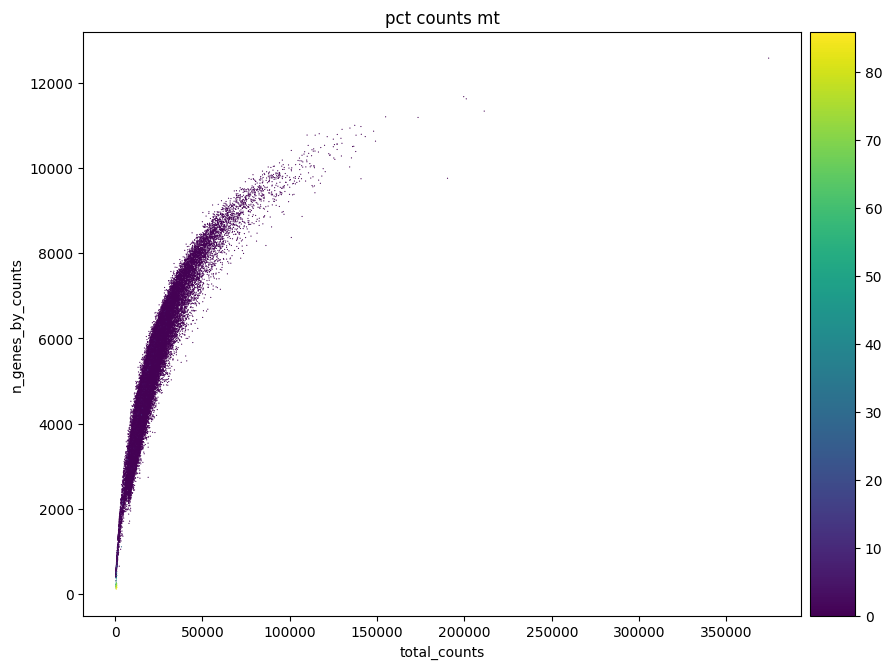

(0.0, 150000.0)

(0.0, 12000.0)

(0.0, 150000.0)

(0.0, 12000.0)

(0.0, 150000.0)

(0.0, 12000.0)

(0.0, 15000.0)

(0.0, 6000.0)

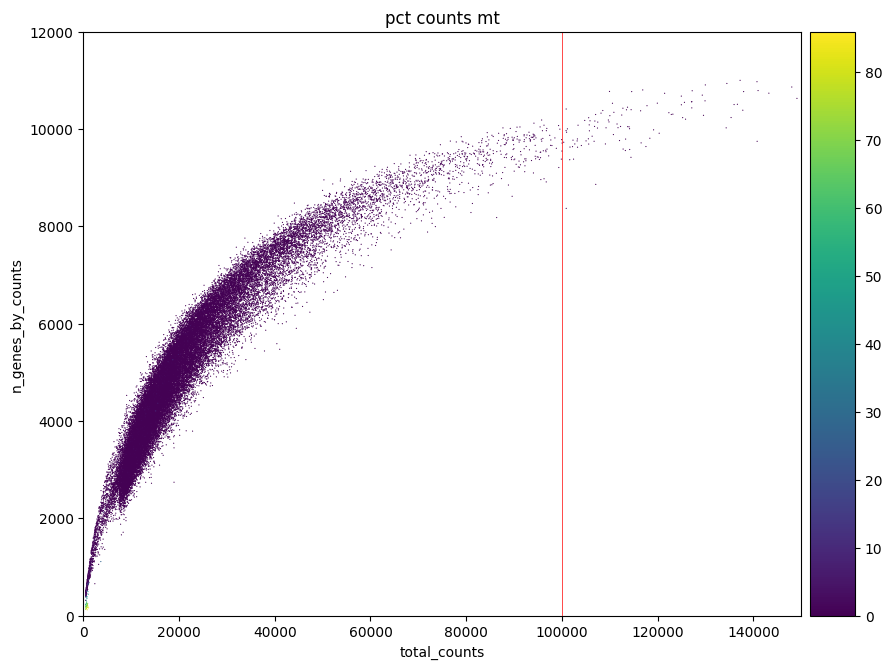

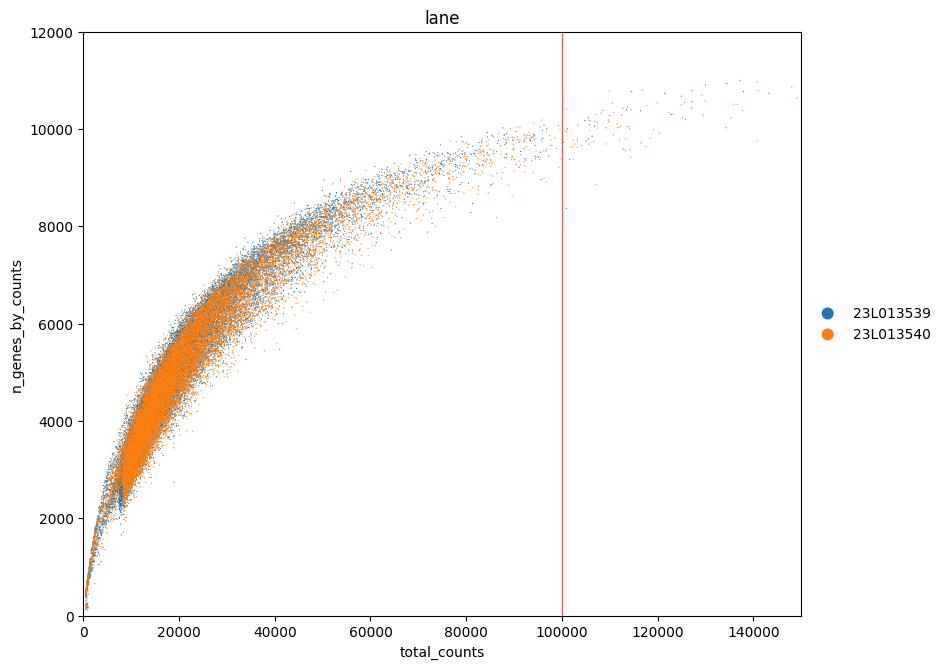

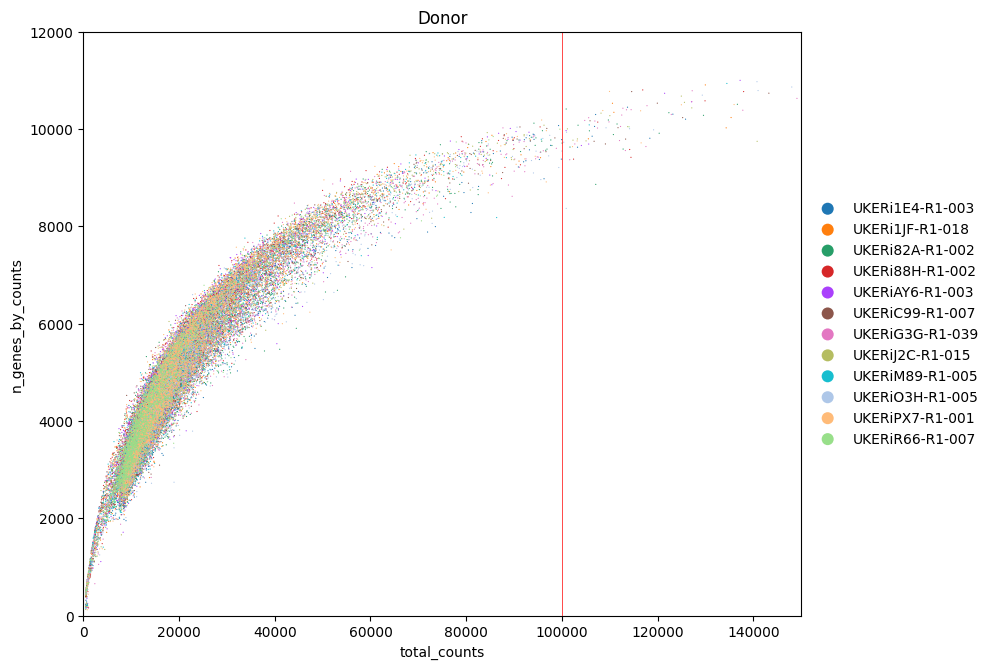

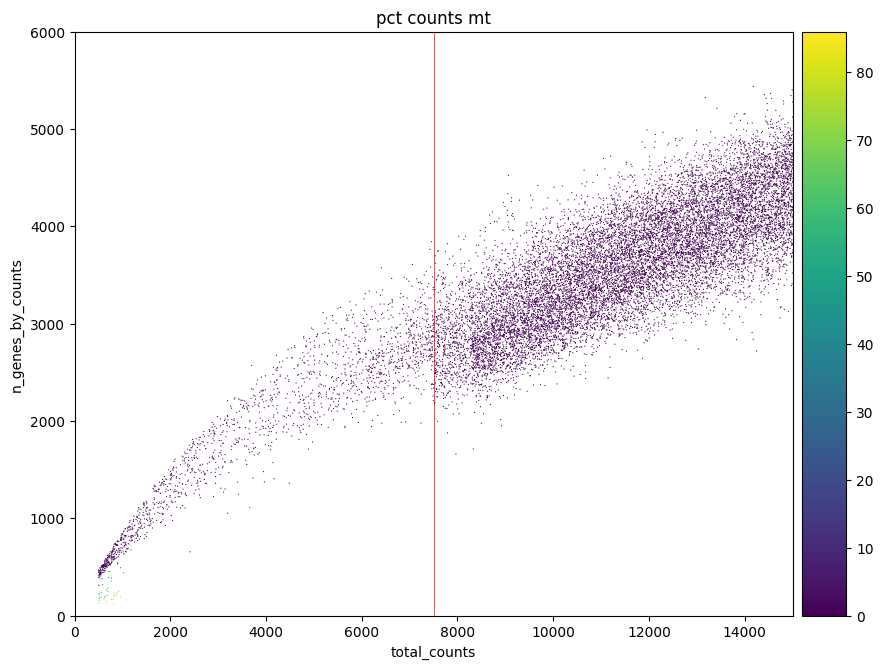

In [36]:
#Data quality summary plots
p1 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')
p2 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', show=False)
p2.set_xlim(0,150000)
p2.set_ylim(0,12000)
p2.axvline(100000,0,9000, color='red', linewidth=0.5)
p3 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color='lane', show=False)
p3.set_xlim(0,150000)
p3.set_ylim(0,12000)
p3.axvline(100000,0,9000, color='red', linewidth=0.5)
p4 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color='Donor', show=False)
p4.set_xlim(0,150000)
p4.set_ylim(0,12000)
p4.axvline(100000,0,9000, color='red', linewidth=0.5)
p5 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', show=False)
p5.set_xlim(0,15000)
p5.set_ylim(0,6000)
p5.axvline(7500,0,9000, color='red', linewidth=0.5)


Here it looks like n_genes < 2,000 as well as total counts < 7,500 and > 100,000 should be filtered out. 
Precise n_genes tresholds will be determined in the following.

## Filtering per sample

In [37]:
adata_tmp = adata_lp.copy()

In [38]:
#adata_lp = adata_tmp.copy()

In [39]:
a,b = np.unique(adata_lp.obs['lane'], return_index=True)
sample_id = a[np.argsort(b)]
ro.globalenv['sample_id'] = sample_id

In [40]:
#QC with automatic thresholding and filtering based on MAD
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * mean_abs_deviation(M)) | (
        np.median(M) + nmads * mean_abs_deviation(M) < M
    )
    return outlier

In [41]:
from numpy import mean, absolute

def mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * mad(M)) | (
        np.median(M) + nmads * mad(M) < M
    )
    return outlier


 23L013539 

outlier counts:


outlier
False    20476
True       262
Name: count, dtype: int64

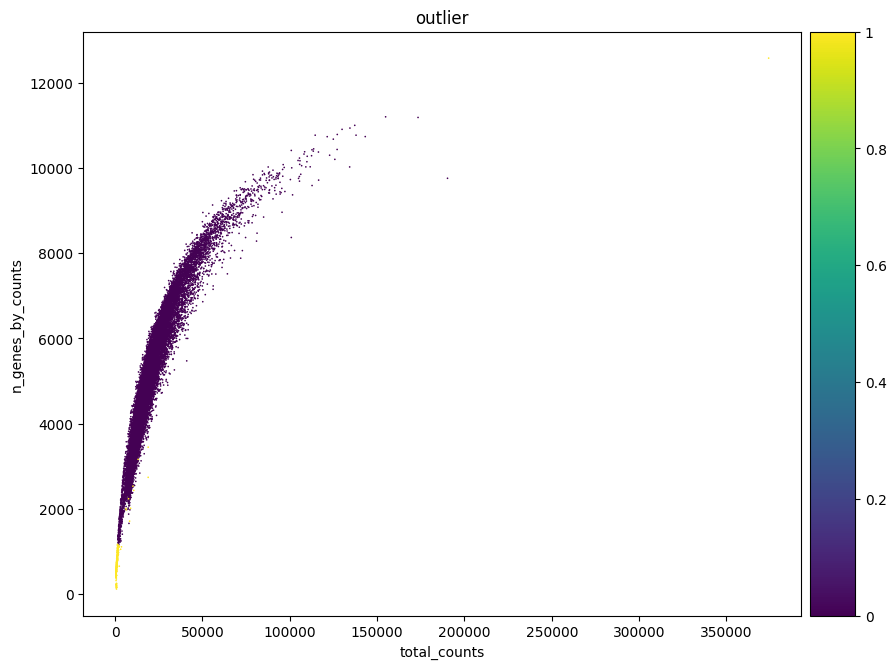

mt outlier counts:


mt_outlier
False    20334
True       404
Name: count, dtype: int64

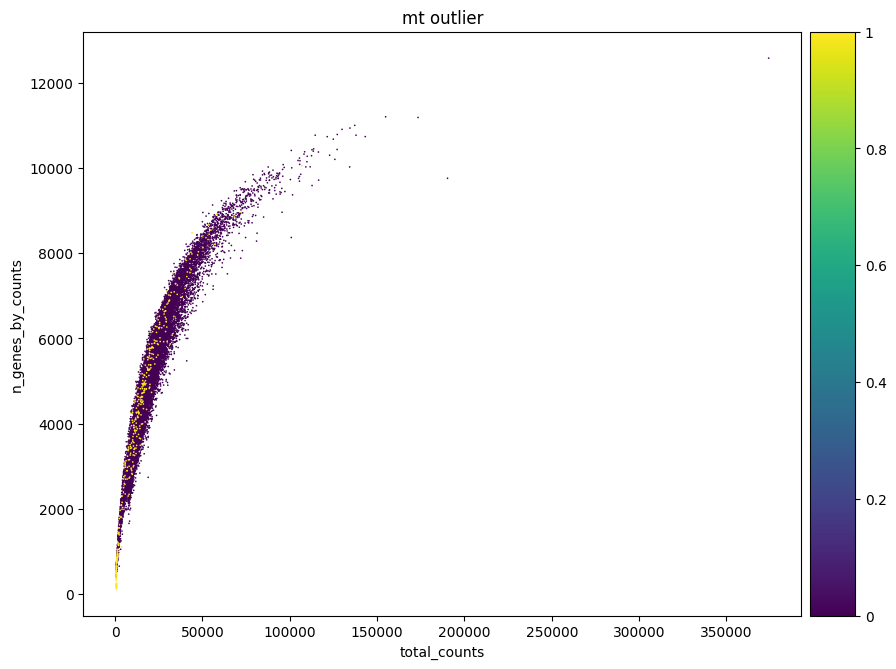


 23L013540 

outlier counts:


outlier
False    20169
True       195
Name: count, dtype: int64

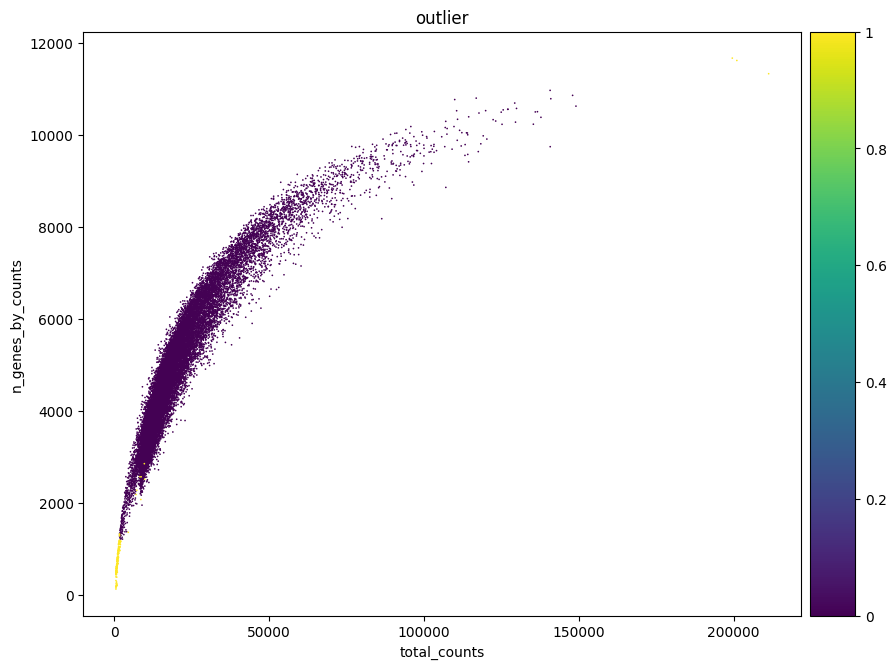

mt outlier counts:


mt_outlier
False    20028
True       336
Name: count, dtype: int64

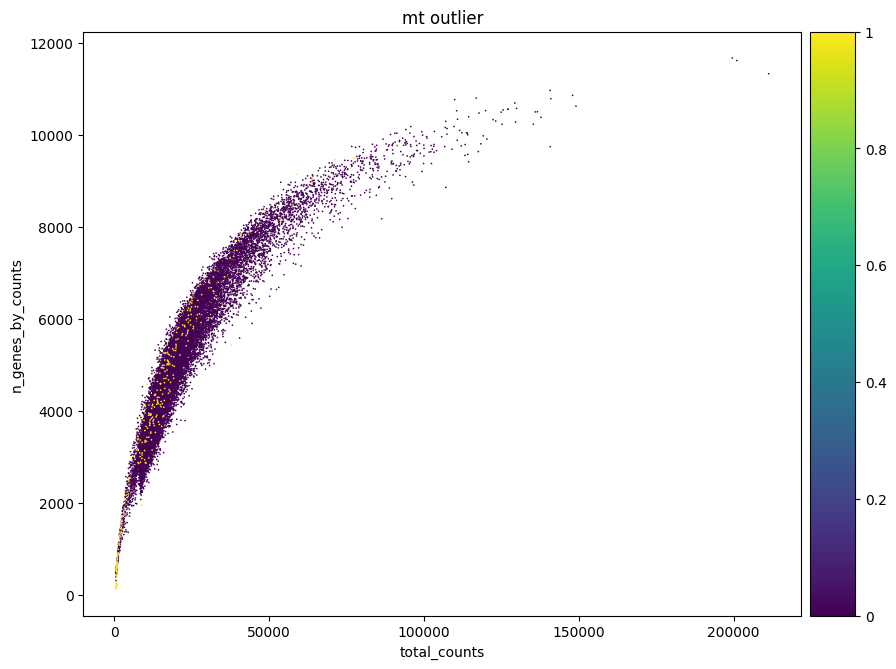

In [42]:
adatas =[]
for sample in enumerate(sample_id):
    print('\n', sample[1], '\n')
    adata_qc = adata_lp[adata_lp.obs['lane']==sample[1]].copy()
    # mitochondrial genes
    adata_qc.var['mt'] = adata_qc.var.gene_symbols.str.startswith('MT-')
    # ribosomal genes
    adata_qc.var['ribo'] = adata_qc.var.gene_symbols.str.startswith(('RPS', 'RPL'))
    # hemoglobin genes.
    adata_qc.var['hb'] = adata_qc.var.gene_symbols.str.contains(('^HB[^(P)]'))
    # calculate qc metrices
    sc.pp.calculate_qc_metrics(adata_qc, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=[20], log1p=True)
    # predict outliers
    adata_qc.obs['outlier'] = (
        is_outlier(adata_qc, 'log1p_total_counts', 5)
        | is_outlier(adata_qc, 'log1p_n_genes_by_counts', 5)
        | is_outlier(adata_qc, 'pct_counts_in_top_20_genes', 5)
    )
    print('outlier counts:')
    adata_qc.obs.outlier.value_counts()
    # plot counts vs genes by counts
    sc.pl.scatter(adata_qc, 'total_counts', 'n_genes_by_counts', color='outlier')
    # predict mt outliers
    adata_qc.obs['mt_outlier'] = is_outlier(adata_qc, 'pct_counts_mt', 3) | (
        adata_qc.obs['pct_counts_mt'] > 15
    )
    
    print('mt outlier counts:')
    adata_qc.obs.mt_outlier.value_counts()
    
    # plot counts vs genes by counts
    sc.pl.scatter(adata_qc, 'total_counts', 'n_genes_by_counts', color='mt_outlier')
    
    adata_qc.var.drop(columns=['mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'], inplace=True)
     
    adatas.append(adata_qc)
    del adata_qc

In [43]:
adata_lp = adatas[0].concatenate(adatas[1:], index_unique = None)

/tmp/ipykernel_98213/3590830230.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_lp = adatas[0].concatenate(adatas[1:], index_unique = None)


In [44]:
del adatas

## Visualize the combined dataset

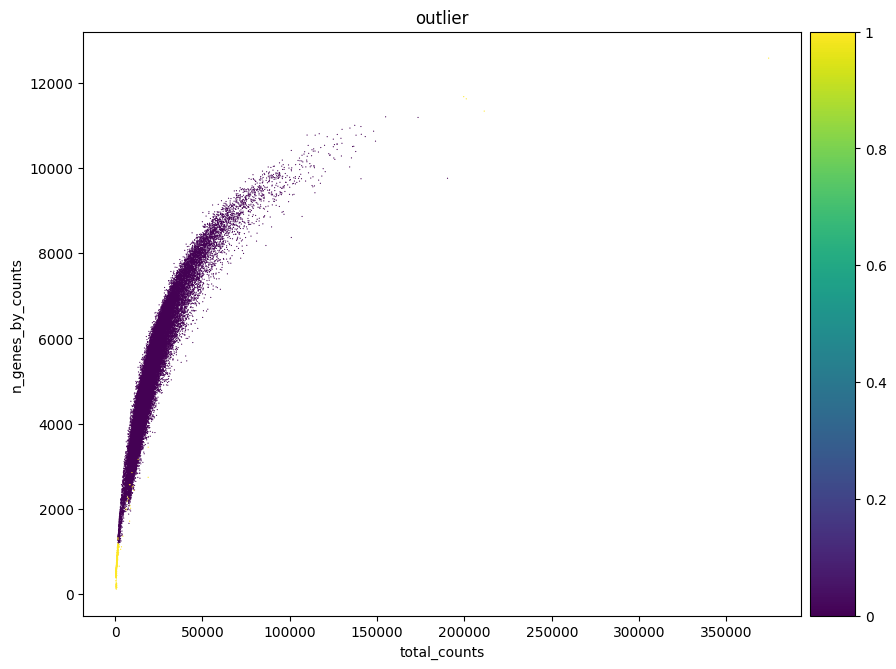

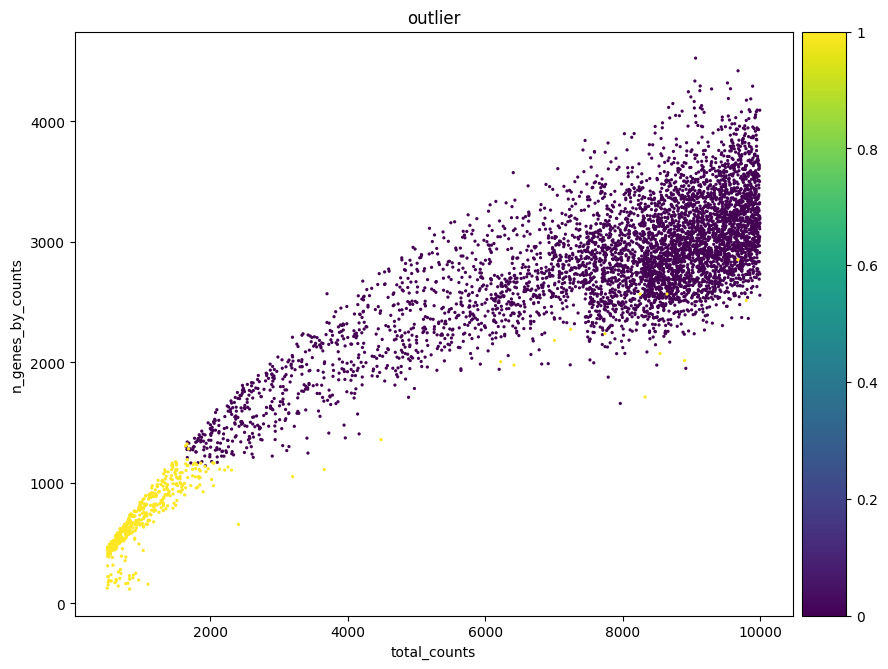

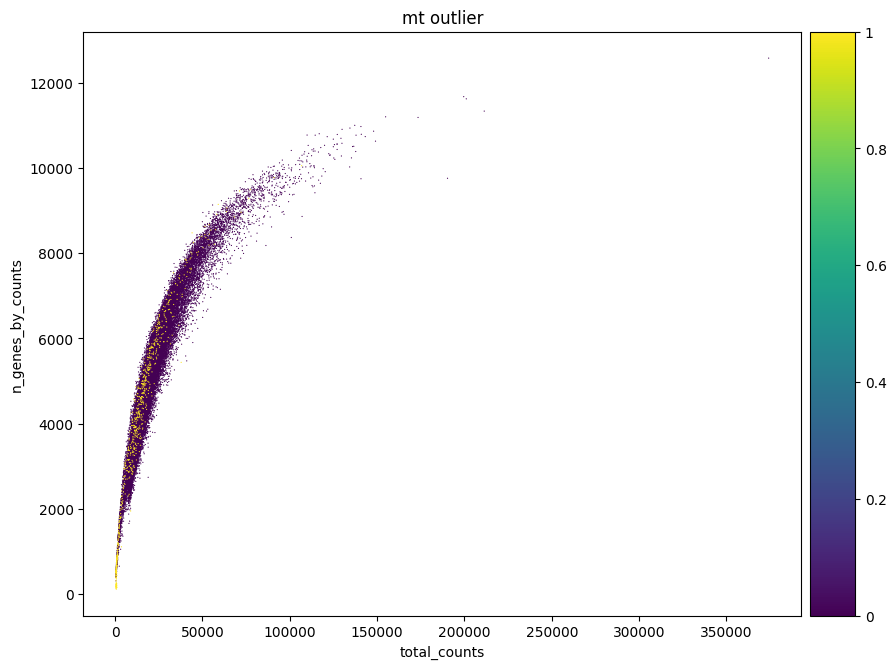

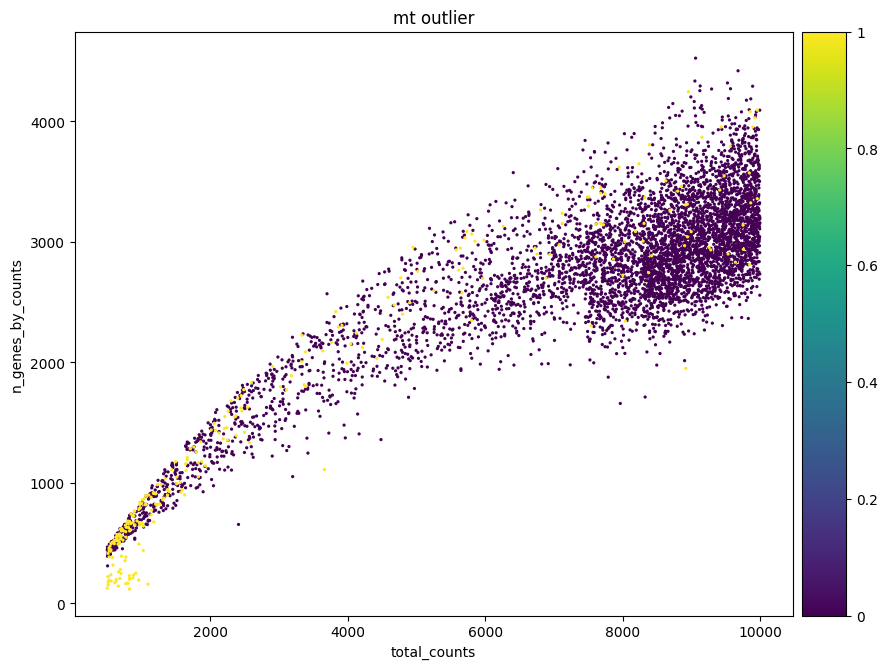

In [45]:
#Data quality summary plots
p3 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color = 'outlier')
p4 = sc.pl.scatter(adata_lp[adata_lp.obs['total_counts']<10000], 'total_counts', 'n_genes_by_counts', color='outlier')
p5 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color = 'mt_outlier')
p6 = sc.pl.scatter(adata_lp[adata_lp.obs['total_counts']<10000], 'total_counts', 'n_genes_by_counts', color='mt_outlier')

Total counts < 7,500 and > 100,000 should be filtered out. 

In [46]:
print(f'Total number of cells: {adata_lp.n_obs}')

adata_lp = adata_lp[(~adata_lp.obs.outlier) & (~adata_lp.obs.mt_outlier)].copy()

print(f'Number of cells after filtering of low quality cells: {adata_lp.n_obs}')

sc.pp.filter_cells(adata_lp, min_counts = 7500)
sc.pp.filter_cells(adata_lp, max_counts = 100000)

print('Number of cells after min and max count filter: {:d}'.format(adata_lp.n_obs))

print(f'n_genes_by_counts treshold: {adata_lp.obs.n_genes_by_counts.min()}')


Total number of cells: 41102
Number of cells after filtering of low quality cells: 40052
filtered out 1262 cells that have less than 7500 counts
filtered out 105 cells that have more than 100000 counts
Number of cells after min and max count filter: 38685
n_genes_by_counts treshold: 1659


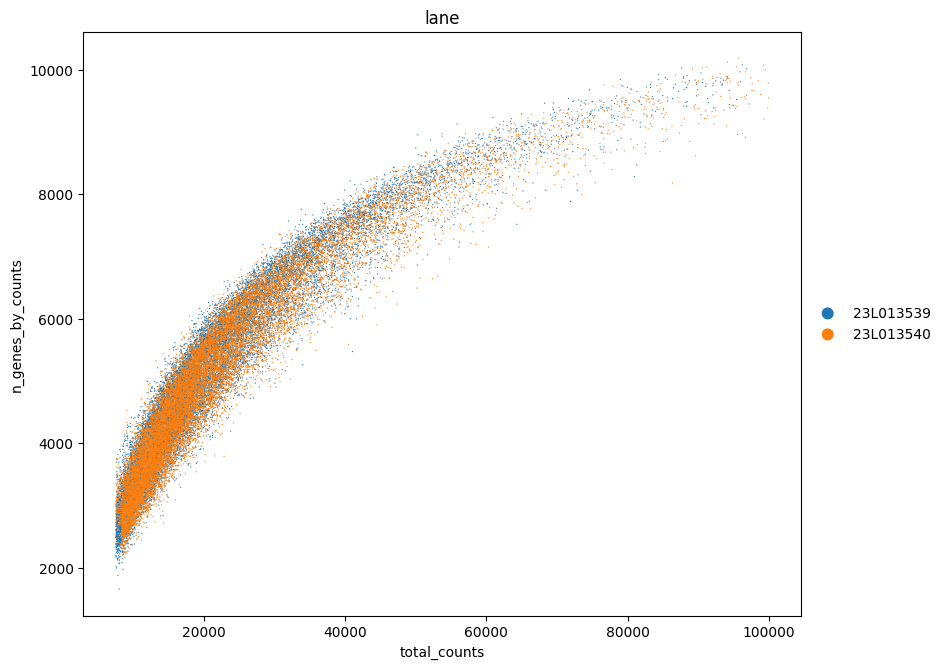

In [47]:
p1 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', color='lane')

(0.0, 150000.0)

(0.0, 12000.0)

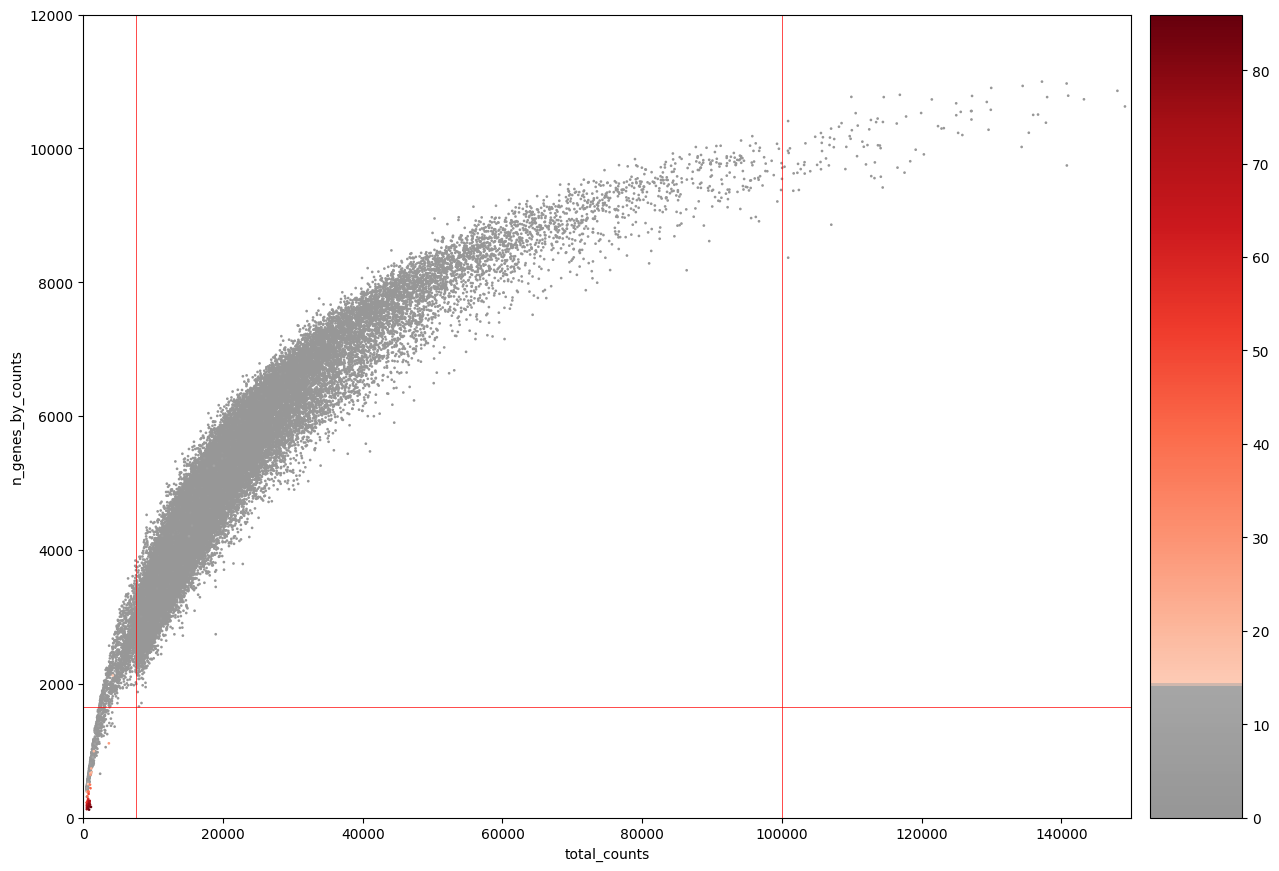

In [48]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 150))
colors3 = plt.cm.Greys_r(np.linspace(0.5,0.55,30))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# QC plot for manuscript
plt.rcParams['figure.figsize']=(11,11) #rescale figures
p1 = sc.pl.scatter(adata_tmp, 'total_counts', 'n_genes_by_counts', color_map=mymap, color='pct_counts_mt', show=False, title='', size=15)
p1.set_xlim(0,150000)
p1.set_ylim(0,12000)
p1.axvline(100000,0,9000, color='red', linewidth=0.5)
p1.axvline(7500,0,9000, color='red', linewidth=0.5)
p1.axhline(adata_lp.obs.n_genes_by_counts.min(),0,75000, color='red', linewidth=0.5)
plt.savefig('lp_NPCs/figures/QC/scatter_figure_qcplot_before-filtering.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

(0.0, 150000.0)

(0.0, 12000.0)

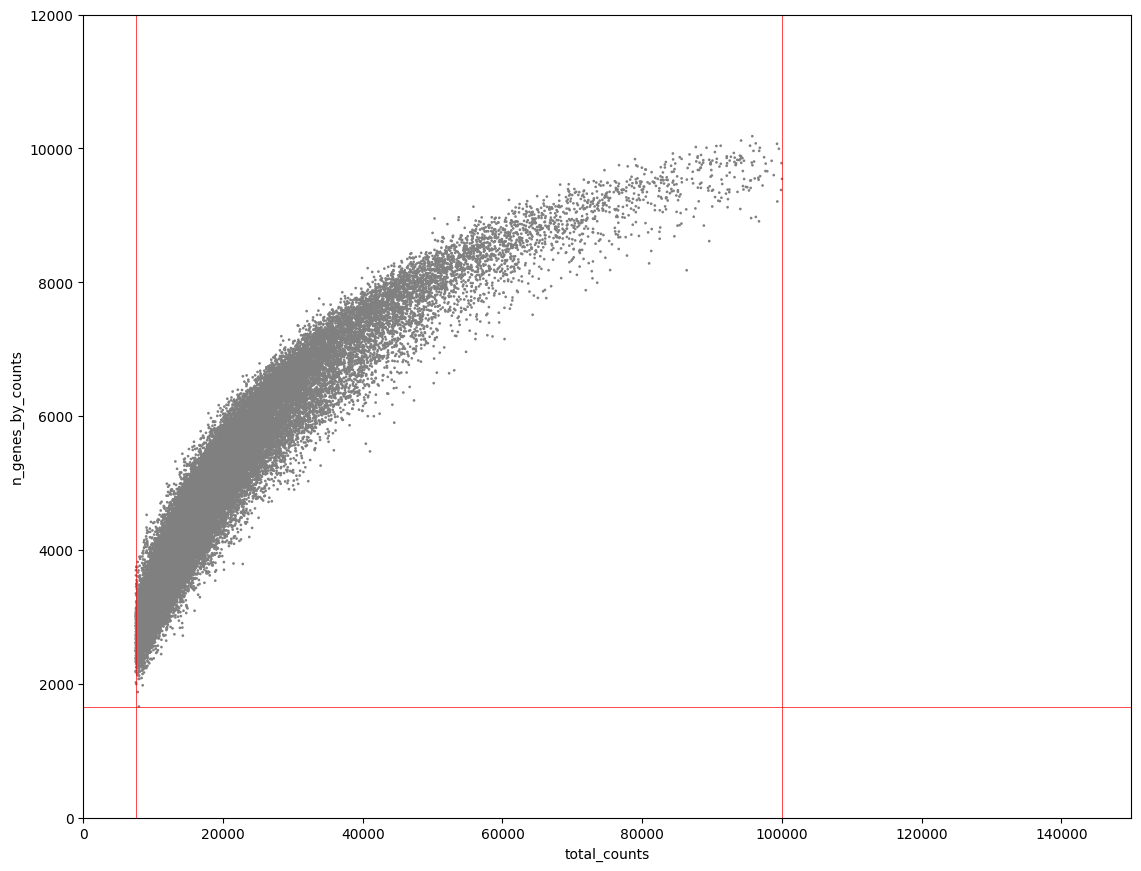

In [49]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 150))
colors3 = plt.cm.Greys_r(np.linspace(0.5,0.55,30))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# QC plot for manuscript
plt.rcParams['figure.figsize']=(11,11) #rescale figures
p1 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', show=False, title='', size=15)
p1.set_xlim(0,150000)
p1.set_ylim(0,12000)
p1.axvline(100000,0,9000, color='red', linewidth=0.5)
p1.axvline(7500,0,9000, color='red', linewidth=0.5)
p1.axhline(adata_lp.obs.n_genes_by_counts.min(),0,75000, color='red', linewidth=0.5)
plt.savefig('lp_NPCs/figures/QC/scatter_figure_qcplot_after-filtering.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

# Quality Control - Correction of ambient RNA

In [50]:
adata_tmp = adata_lp.copy()

In [51]:
#adata_lp = adata_tmp.copy()

In [52]:
adata_lp.obs

Demux_state            Donor       lane  condition  \
AAACCCAAGAAGGATG-23L013539         DBL  UKERi82A-R1-002  23L013539    Control   
AAACCCAAGACTCTAC-23L013539         SNG  UKERiC99-R1-007  23L013539  Parkinson   
AAACCCAAGATCACCT-23L013539         SNG  UKERiG3G-R1-039  23L013539    Control   
AAACCCACAAAGGCGT-23L013539         DBL  UKERiPX7-R1-001  23L013539  Parkinson   
AAACCCACAATAGAGT-23L013539         SNG  UKERiAY6-R1-003  23L013539  Parkinson   
...                                ...              ...        ...        ...   
TTTGTTGGTTCGAACT-23L013540         SNG  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGGTTCGATTG-23L013540         DBL  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGGTTCTCAGA-23L013540         SNG  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGTCGGTCGGT-23L013540         SNG  UKERiPX7-R1-001  23L013540  Parkinson   
TTTGTTGTCGTTCTGC-23L013540         SNG  UKERiG3G-R1-039  23L013540    Control   

                             age  years_of_illness  deltaHY  deltaUPDRS  \
AAACCCAAGAAGGATG-23L013539  66.0               NaN      NaN         NaN   
AAACCCAAGACTCTAC-23L013539  68.0               7.0      2.5        36.0   
AAACCCAAGATCACCT-23L013539  69.0               NaN      NaN         NaN   
AAACCCACAAAGGCGT-23L013539  49.0               1.0      1.0         0.0   
AAACCCACAATAGAGT-23L013539  37.0               4.0      1.0        -1.0   
...                          ...               ...      ...         ...   
TTTGTTGGTTCGAACT-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGGTTCGATTG-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGGTTCTCAGA-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGTCGGTCGGT-23L013540  49.0               1.0      1.0         0.0   
TTTGTTGTCGTTCTGC-23L013540  69.0               NaN      NaN         NaN   

                            deltaADL  deltaDOPA  ... total_counts_ribo  \
AAACCCAAGAAGGATG-23L013539       NaN        NaN  ...            9789.0   
AAACCCAAGACTCTAC-23L013539      -0.5      610.0  ...            5284.0   
AAACCCAAGATCACCT-23L013539       NaN        NaN  ...            5224.0   
AAACCCACAAAGGCGT-23L013539      -0.1     1900.0  ...            6903.0   
AAACCCACAATAGAGT-23L013539      -0.2      800.0  ...            3777.0   
...                              ...        ...  ...               ...   
TTTGTTGGTTCGAACT-23L013540      -0.1     1900.0  ...            2445.0   
TTTGTTGGTTCGATTG-23L013540      -0.1     1900.0  ...           14075.0   
TTTGTTGGTTCTCAGA-23L013540      -0.1     1900.0  ...            1673.0   
TTTGTTGTCGGTCGGT-23L013540      -0.1     1900.0  ...            5053.0   
TTTGTTGTCGTTCTGC-23L013540       NaN        NaN  ...            4560.0   

                           log1p_total_counts_ribo  pct_counts_ribo  \
AAACCCAAGAAGGATG-23L013539                9.189116        25.631693   
AAACCCAAGACTCTAC-23L013539                8.572628        20.447332   
AAACCCAAGATCACCT-23L013539                8.561210        20.539436   
AAACCCACAAAGGCGT-23L013539                8.839856        16.747944   
AAACCCACAATAGAGT-23L013539                8.236950        16.765802   
...                                            ...              ...   
TTTGTTGGTTCGAACT-23L013540                7.802209        25.788418   
TTTGTTGGTTCGATTG-23L013540                9.552226        21.902184   
TTTGTTGGTTCTCAGA-23L013540                7.422971        13.570733   
TTTGTTGTCGGTCGGT-23L013540                8.527935        17.993732   
TTTGTTGTCGTTCTGC-23L013540                8.425297        24.403296   

                            total_counts_hb  log1p_total_counts_hb  \
AAACCCAAGAAGGATG-23L013539              2.0               1.098612   
AAACCCAAGACTCTAC-23L013539              6.0               1.945910   
AAACCCAAGATCACCT-23L013539              1.0               0.693147   
AAACCCACAAAGGCGT-23L013539              2.0               1.098612   
AAACCCACAATAGAGT-23L013539              0.0               0.0

In [53]:
adata_lp.var

gene_ids    feature_types  \
ATAD3B           ENSG00000160072  Gene Expression   
PRDM16           ENSG00000142611  Gene Expression   
PEX10            ENSG00000157911  Gene Expression   
PEX14            ENSG00000142655  Gene Expression   
PLCH2            ENSG00000149527  Gene Expression   
...                          ...              ...   
ENSG00000275063  ENSG00000275063  Gene Expression   
ENSG00000277856  ENSG00000277856  Gene Expression   
ENSG00000271254  ENSG00000271254  Gene Expression   
ENSG00000268674  ENSG00000268674  Gene Expression   
ENSG00000277475  ENSG00000277475  Gene Expression   

                                                         genome  \
ATAD3B           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PRDM16           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX10            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX14            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PLCH2            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
...                                                         ...   
ENSG00000275063  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000277856  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000271254  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000268674  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000277475  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   

                    gene_symbols  
ATAD3B                    ATAD3B  
PRDM16                    PRDM16  
PEX10                      PEX10  
PEX14                      PEX14  
PLCH2                      PLCH2  
...                          ...  
ENSG00000275063  ENSG00000275063  
ENSG00000277856  ENSG00000277856  
ENSG00000271254  ENSG00000271254  
ENSG00000268674  ENSG00000268674  
ENSG00000277475  ENSG00000277475  

[20682 rows x 4 columns]

## Preprocess datasets

In [54]:
adatas =[]
adatas_pp =[]
for sample in enumerate(sample_id):
    print('\n', sample[1], '\n')
    adata_pp = adata_lp[adata_lp.obs['lane']==sample[1]].copy()
    adata = adata_lp[adata_lp.obs['lane']==sample[1]].copy()
    # Preprocess variables for SoupX
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added='soupx_groups')

    # send to R
    ro.globalenv['soupx_groups_'+str(sample[1])] = adata_pp.obs['soupx_groups']   
    ro.globalenv['cells_'+str(sample[1])] = adata.obs_names
    ro.globalenv['genes_'+str(sample[1])] = adata.var_names
    data = adata.X.T
    if sp.sparse.issparse(data):
        if data.nnz > 2**31 - 1:
            data = data.tocoo()
        else:
            data = data.tocsc()
    ro.globalenv['data_'+str(sample[1])] = data
    
    adatas.append(adata)
    adatas_pp.append(adata_pp)
    del adata_pp
    del adata


 23L013539 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:01:06)
computing neighbors
    using 'X_pca' with n_pcs = 50


2024-05-16 16:40:41.488853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
running Leiden clustering


/tmp/ipykernel_98213/3108055979.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added='soupx_groups')


    finished: found 23 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:13)

 23L013540 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:01:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 20 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:10)


## Load full dataset

In [55]:
#Filnames scanpy AnnData for raw NPC samples
adata_raw_input_1 = 'lp_NPCs/raw_data/23L013539/23L013539_raw_feature_bc_matrix.h5'
adata_raw_input_2 = 'lp_NPCs/raw_data/23L013540/23L013540_raw_feature_bc_matrix.h5'

In [56]:
adata_raw_1 = sc.read_10x_h5(filename=adata_raw_input_1)
adata_raw_2 = sc.read_10x_h5(filename=adata_raw_input_2)

reading lp_NPCs/raw_data/23L013539/23L013539_raw_feature_bc_matrix.h5
 (0:00:07)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading lp_NPCs/raw_data/23L013540/23L013540_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:07)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [57]:
adata_raw_1.var['gene_symbols'] = adata_raw_1.var_names
adata_raw_2.var['gene_symbols'] = adata_raw_2.var_names

In [58]:
adata_raw_1.var_names_make_unique()
adata_raw_2.var_names_make_unique()

In [59]:
adata_raw_1.obs_names = adata_raw_1.obs_names.str.split('-').str[0].astype('str')
adata_raw_2.obs_names = adata_raw_2.obs_names.str.split('-').str[0].astype('str')

In [60]:
adata_raw = adata_raw_1.concatenate(adata_raw_2, batch_key = 'lane', batch_categories = ['23L013539', '23L013540'])
del adata_raw_1
del adata_raw_2

/tmp/ipykernel_98213/2590977051.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_raw = adata_raw_1.concatenate(adata_raw_2, batch_key = 'lane', batch_categories = ['23L013539', '23L013540'])


In [61]:
adata_raw.obs

lane
AAACCCAAGAAACACT-23L013539  23L013539
AAACCCAAGAAACCCA-23L013539  23L013539
AAACCCAAGAAACCCG-23L013539  23L013539
AAACCCAAGAAACGAA-23L013539  23L013539
AAACCCAAGAAACTAC-23L013539  23L013539
...                               ...
TTTGTTGTCTTTGCGC-23L013540  23L013540
TTTGTTGTCTTTGCTA-23L013540  23L013540
TTTGTTGTCTTTGCTG-23L013540  23L013540
TTTGTTGTCTTTGGAG-23L013540  23L013540
TTTGTTGTCTTTGGCT-23L013540  23L013540

[6159013 rows x 1 columns]

In [62]:
adata_raw.var

gene_ids    feature_types  \
ATAD3B           ENSG00000160072  Gene Expression   
PRDM16           ENSG00000142611  Gene Expression   
PEX10            ENSG00000157911  Gene Expression   
PEX14            ENSG00000142655  Gene Expression   
PLCH2            ENSG00000149527  Gene Expression   
...                          ...              ...   
ENSG00000275063  ENSG00000275063  Gene Expression   
ENSG00000277856  ENSG00000277856  Gene Expression   
ENSG00000271254  ENSG00000271254  Gene Expression   
ENSG00000268674  ENSG00000268674  Gene Expression   
ENSG00000277475  ENSG00000277475  Gene Expression   

                                                         genome  \
ATAD3B           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PRDM16           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX10            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX14            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PLCH2            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
...                                                         ...   
ENSG00000275063  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000277856  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000271254  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000268674  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000277475  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   

                    gene_symbols  
ATAD3B                    ATAD3B  
PRDM16                    PRDM16  
PEX10                      PEX10  
PEX14                      PEX14  
PLCH2                      PLCH2  
...                          ...  
ENSG00000275063  ENSG00000275063  
ENSG00000277856  ENSG00000277856  
ENSG00000271254  ENSG00000271254  
ENSG00000268674  ENSG00000268674  
ENSG00000277475  ENSG00000277475  

[20682 rows x 4 columns]

In [63]:
adatas_tod =[]
for sample in enumerate(sample_id):
    adata_tod = adata_raw[adata_raw.obs['lane']==sample[1]].copy()
    data_tod = adata_tod.X.T
    
    if sp.sparse.issparse(data_tod):
        if data_tod.nnz > 2**31 - 1:
            data_tod = data_tod.tocoo()
        else:
            data = data_tod.tocsc()
    # send to R
    ro.globalenv['data_tod_'+str(sample[1])] = data_tod
    ro.globalenv['cells_tod_'+str(sample[1])] = adata_tod.obs_names
    ro.globalenv['genes_tod_'+str(sample[1])] = adata_tod.var_names
    adatas_tod.append(adata_tod)
    del adata_tod
    del data

## Run SoupX

In [64]:
%%R

out <- list()

for (sample in sample_id){
    # specify variables
    data = eval(parse(text = paste0('data_', sample)))
    data_tod = eval(parse(text = paste0('data_tod_', sample)))
    genes = eval(parse(text = paste0('genes_', sample)))
    genes_tod = eval(parse(text = paste0('genes_tod_', sample)))
    cells = eval(parse(text = paste0('cells_', sample)))
    cells_tod = eval(parse(text = paste0('cells_tod_', sample)))
    soupx_groups = eval(parse(text = paste0('soupx_groups_', sample)))
    
    # specify row and column names of data
    rownames(data) = genes
    colnames(data) = cells

    rownames(data_tod) = genes_tod
    colnames(data_tod) = cells_tod

    # ensure correct sparse format for table of counts and table of droplets
    #data <- as(data, 'sparseMatrix')
    #data_tod <- as(data_tod, 'sparseMatrix')

    # Generate SoupChannel Object for SoupX 
    sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

    # Add extra meta data to the SoupChannel object
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    # Set cluster information in SoupChannel
    sc = setClusters(sc, soupx_groups)

    # Estimate contamination fraction; tfidMin and soupQuantile decreased to get more/better markers
    sc  = autoEstCont(sc, tfidfMin = 0.9, soupQuantile = 0.7, doPlot=FALSE)
    # Infer corrected table of counts and rount to integer
    out[[sample]] = adjustCounts(sc, roundToInt = TRUE)  
    
}

593 genes passed tf-idf cut-off and 59 soup quantile filter.  Taking the top 59.
Using 117 independent estimates of rho.
Estimated global rho of 0.09
Expanding counts from 23 clusters to 19336 cells.
542 genes passed tf-idf cut-off and 61 soup quantile filter.  Taking the top 61.
Using 107 independent estimates of rho.
Estimated global rho of 0.07
Expanding counts from 20 clusters to 19349 cells.
In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
3: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you
4: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [65]:
out = ro.globalenv['out']

In [66]:
%%R
rm(list = ls())

In [67]:
out_list = list(collections.OrderedDict(out).values())


In [68]:
for sample in range(0,2):
    adatas[sample].layers['counts'] = adatas[sample].X
    adatas[sample].layers['soupX_counts'] = out_list[sample].T
    adatas[sample].X = adatas[sample].layers['soupX_counts']

In [69]:
adata_lp = adatas[0].concatenate(adatas[1:], index_unique = None)

/tmp/ipykernel_98213/3590830230.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_lp = adatas[0].concatenate(adatas[1:], index_unique = None)


In [70]:
print(f'Total number of genes: {adata_lp.n_vars}')

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_lp, min_cells=20)
print(f'Number of genes after cell filter: {adata_lp.n_vars}')

Total number of genes: 20682
filtered out 3432 genes that are detected in less than 20 cells
Number of genes after cell filter: 17250


In [71]:
del adata_raw

# Quality Control - identify remaining DBLs and remove AMBs

In [72]:
adata_tmp = adata_lp.copy()

In [73]:
adata_lp = adata_tmp.copy()

In [74]:
a,b = np.unique(adata_lp.obs['lane'], return_index=True)
sample_id = a[np.argsort(b)]
sample_id

array(['23L013539', '23L013540'], dtype=object)

In [75]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.06 
sim_doublet_ratio = 3
n_neighbors = 15
adatas = []
for sample in enumerate(sample_id):
    print('\n', sample[1], '\n')
    adata_qc = adata_lp[adata_lp.obs['lane']==sample[1]].copy()
    scrub = scr.Scrublet(counts_matrix = adata_qc.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

   
    adata_qc.obs['doublet_score'] = doublet_scores
    adata_qc.obs['doublet'] = predicted_doublets
    
    adatas.append(adata_qc)
    del adata_qc
    


 23L013539 

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 8.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 12.5%
Elapsed time: 35.0 seconds

 23L013540 

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 6.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 16.3%
Elapsed time: 34.8 seconds


In [76]:
adata_lp = adatas[0].concatenate(adatas[1:], index_unique = None)

/tmp/ipykernel_98213/3590830230.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_lp = adatas[0].concatenate(adatas[1:], index_unique = None)


In [77]:
del adatas

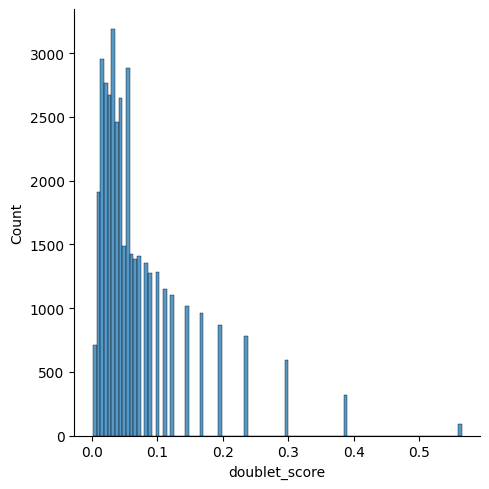

In [78]:
rcParams['figure.figsize']=(6,6)
sb.displot(adata_lp.obs['doublet_score'], bins=100, kde=False)

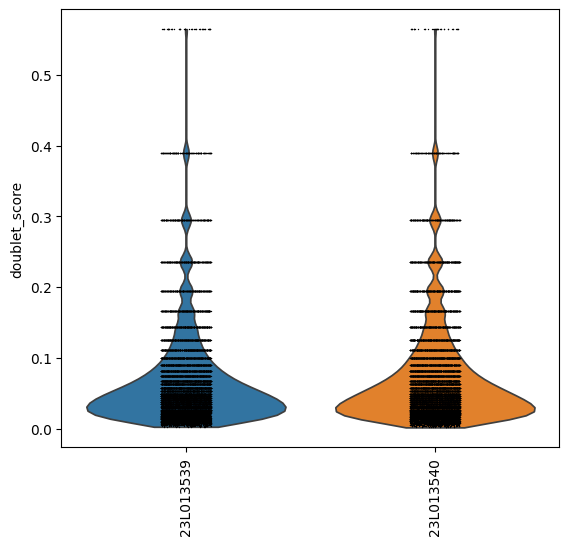

In [79]:
sc.pl.violin(adata_lp, ['doublet_score'], groupby='lane', size=1, log=False,rotation=90)

In [80]:
booleanDictionary = {True: 'DBL', False: 'SNG'}
adata_lp.obs['doublet'] = pd.Categorical(adata_lp.obs['doublet'].replace(booleanDictionary))

In [81]:
thr = 0.15
adata_lp.obs['doublet_0.15'] = pd.Categorical(np.where(adata_lp.obs['doublet_score'] <= thr, 'SNG', 'DBL'))

In [82]:
#Combine demuxlet and scrublet infos. Demuxlet info is preferred.
adata_lp.obs['doublet_combined'] = pd.Categorical(np.where(adata_lp.obs['doublet'] == 'DBL', 'DBL', adata_lp.obs['Demux_state']))
adata_lp.obs['doublet_combined_0.15'] = pd.Categorical(np.where(adata_lp.obs['doublet_0.15'] == 'DBL', 'DBL', adata_lp.obs['Demux_state']))

In [83]:
adata_lp.obs['doublet'].value_counts()
adata_lp.obs['doublet_0.15'].value_counts()
adata_lp.obs['doublet_combined'].value_counts()
adata_lp.obs['doublet_combined_0.15'].value_counts()

doublet
SNG    38277
DBL      408
Name: count, dtype: int64

doublet_0.15
SNG    35077
DBL     3608
Name: count, dtype: int64

doublet_combined
SNG    32067
DBL     6618
Name: count, dtype: int64

doublet_combined_0.15
SNG    30843
DBL     7842
Name: count, dtype: int64

In [84]:
adata_tmp = adata_lp.copy()

In [85]:
#Filter cells according to ambiguous reads
print('Total number of cells: {:d}'.format(adata_lp.n_obs))

adata_lp = adata_lp[adata_lp.obs['Demux_state'].isin(['SNG', 'DBL'])]
print('Number of cells after demux filter: {:d}'.format(adata_lp.n_obs))


Total number of cells: 38685
Number of cells after demux filter: 38685


Doublets do not cluster together and are thus directly removed at this step.

In [86]:
#Filter cells according to DBLs
print('Total number of cells: {:d}'.format(adata_lp.n_obs))

adata_lp = adata_lp[adata_lp.obs['doublet_combined_0.15'] == 'SNG']
print('Number of cells after demux filter: {:d}'.format(adata_lp.n_obs))


Total number of cells: 38685
Number of cells after demux filter: 30843


In [87]:
adata_lp.obs.drop(columns=['Demux_state', 'outlier', 'mt_outlier', 'batch', 'doublet', 'doublet_0.15', 'doublet_combined', 'doublet_combined_0.15' ], inplace=True)

# Quality Control - after filtering

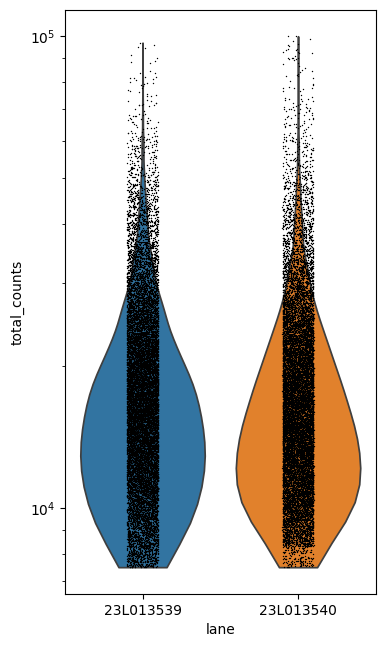

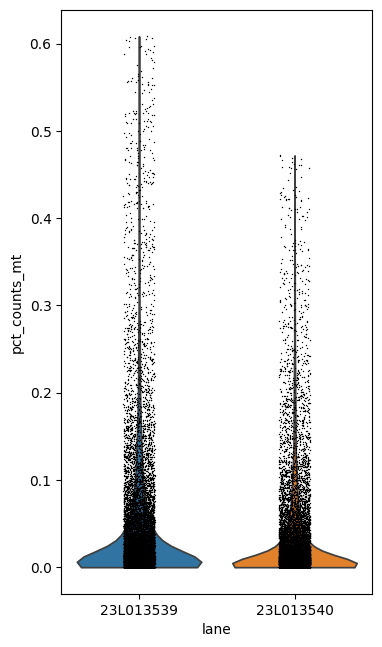

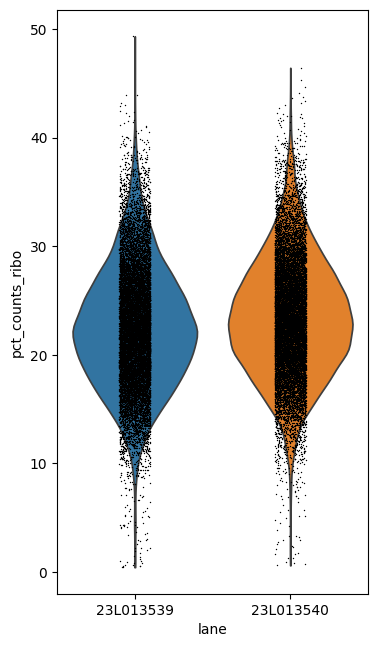

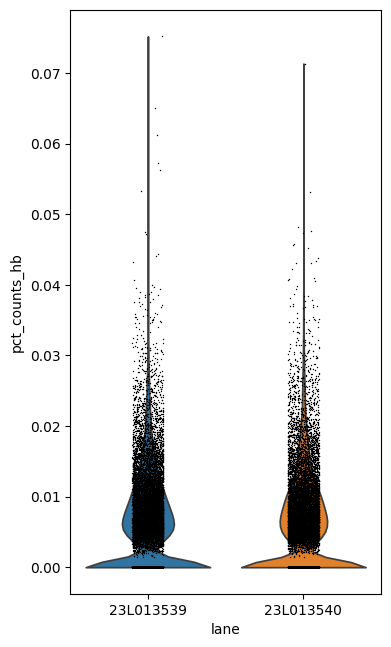

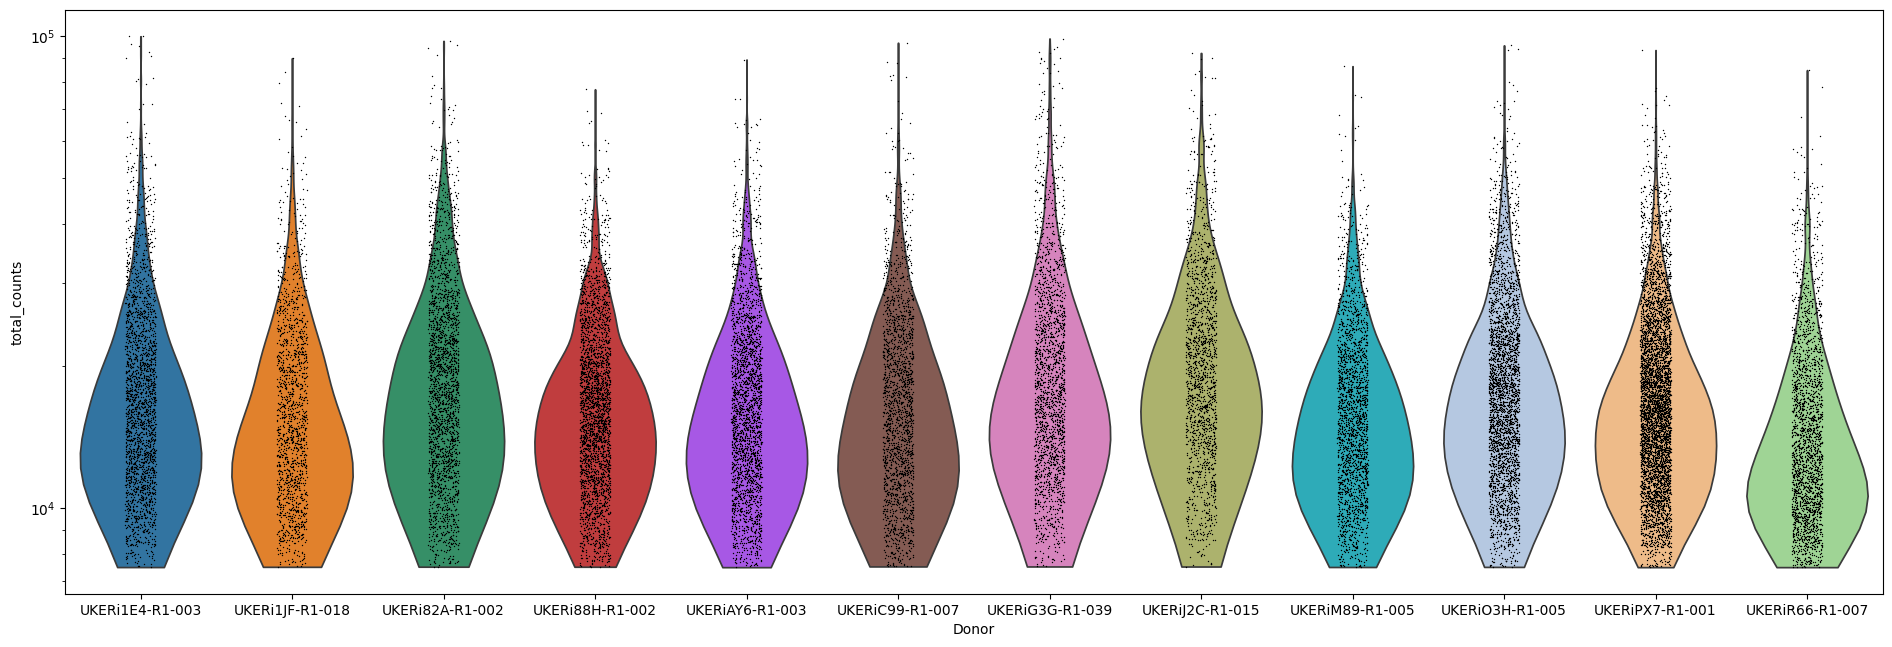

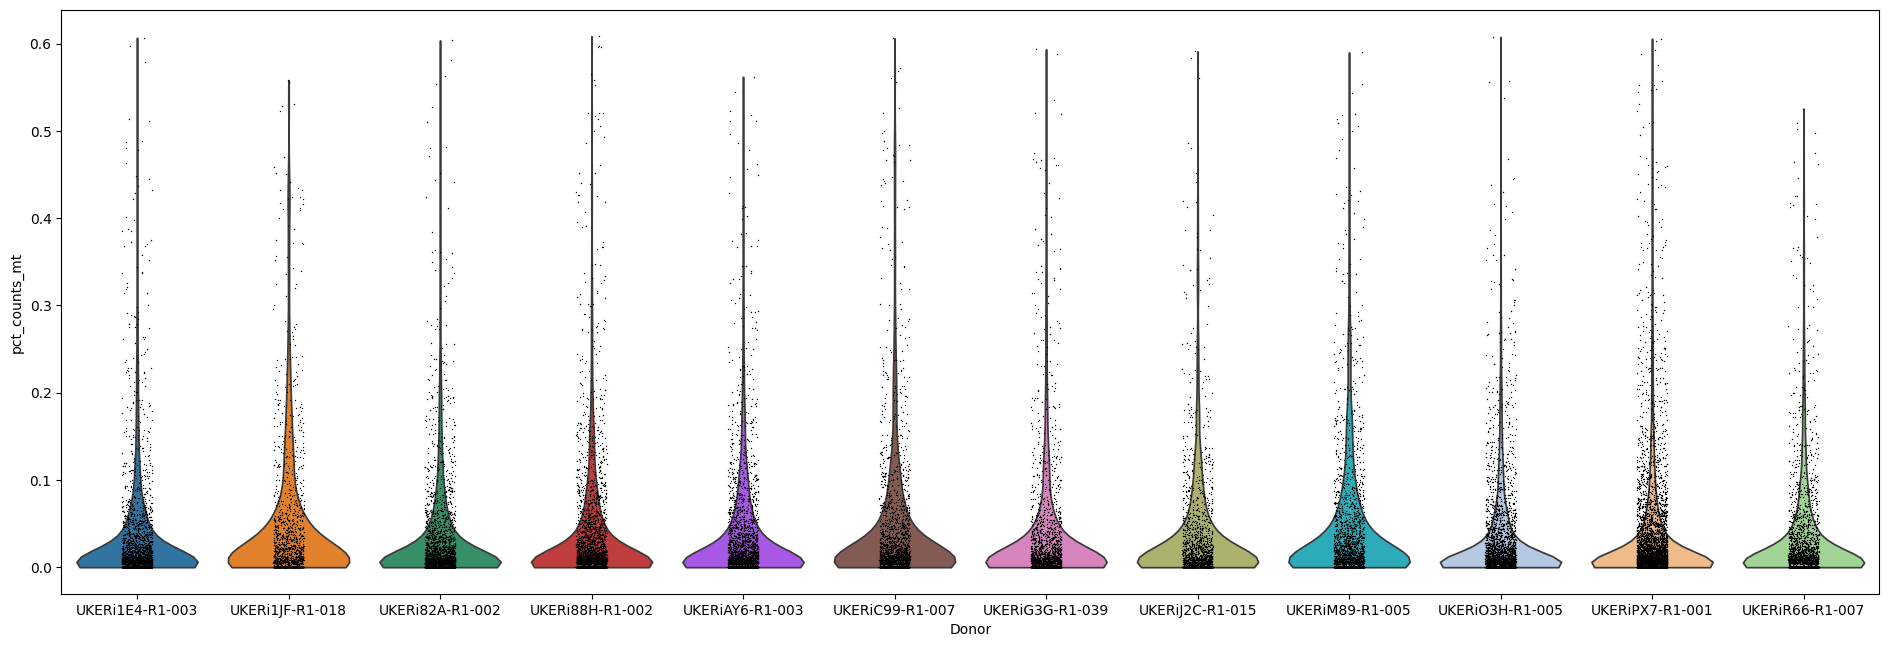

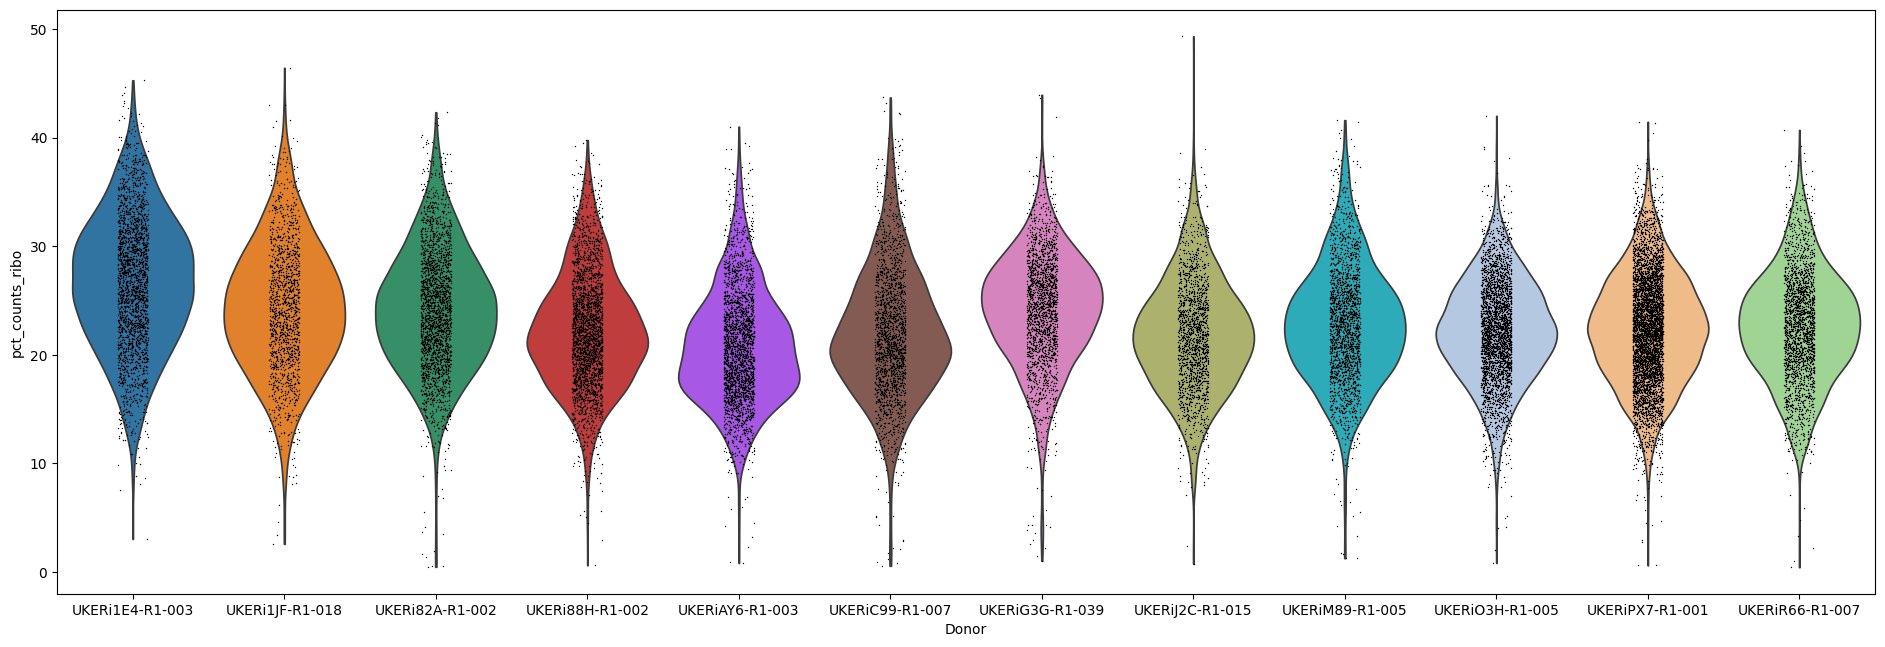

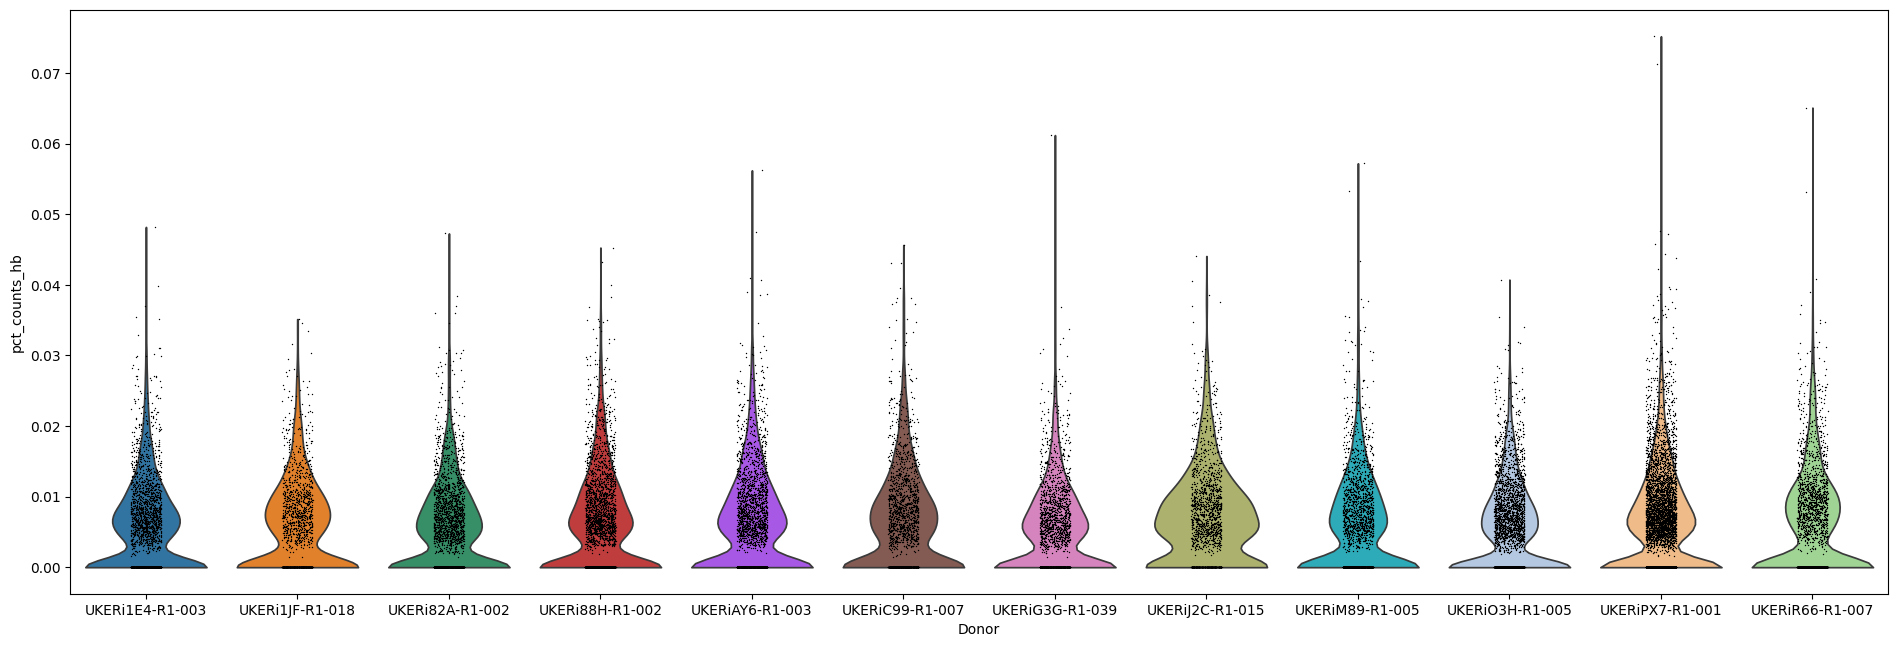

In [88]:
#Sample quality plots
plt.rcParams['figure.figsize']=(4.3,8) #rescale figures
t1 = sc.pl.violin(adata_lp, 'total_counts', groupby='lane', log=True, cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_total_counts.svg')

plt.rcParams['figure.figsize']=(4.3,8) #rescale figures
t2 = sc.pl.violin(adata_lp, 'pct_counts_mt', groupby='lane', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata_lp, 'pct_counts_ribo', groupby='lane', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata_lp, 'pct_counts_hb', groupby='lane', show=False)
plt.savefig('lp_NPCs/figures/QC/Lanes_violin_pct_counts_hb.svg')

plt.rcParams['figure.figsize']=(18,8) #rescale figures
t5 = sc.pl.violin(adata_lp, 'total_counts', groupby='Donor', log=True, cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_total_counts.svg')
t6 = sc.pl.violin(adata_lp, 'pct_counts_mt', groupby='Donor', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata_lp, 'pct_counts_ribo', groupby='Donor', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata_lp, 'pct_counts_hb', groupby='Donor', cut=0, show=False)
plt.savefig('lp_NPCs/figures/QC/Donor_violin_pct_counts_hb.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

(0.0, 150000.0)

(0.0, 12000.0)

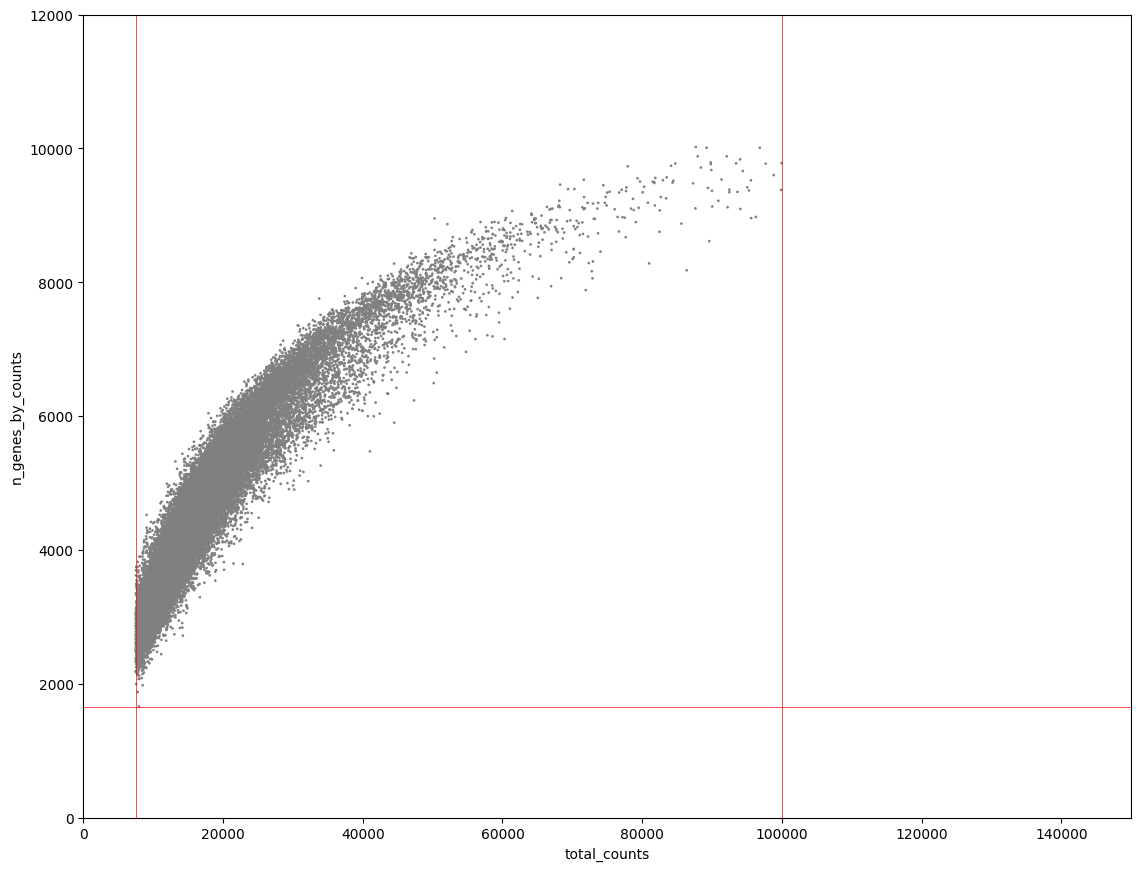

In [89]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 150))
colors3 = plt.cm.Greys_r(np.linspace(0.5,0.55,30))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# QC plot for manuscript
plt.rcParams['figure.figsize']=(11,11) #rescale figures
p1 = sc.pl.scatter(adata_lp, 'total_counts', 'n_genes_by_counts', show=False, title='', size=15)
p1.set_xlim(0,150000)
p1.set_ylim(0,12000)
p1.axvline(100000,0,9000, color='red', linewidth=0.5)
p1.axvline(7500,0,9000, color='red', linewidth=0.5)
p1.axhline(adata_lp.obs.n_genes_by_counts.min(),0,75000, color='red', linewidth=0.5)
plt.savefig('lp_NPCs/figures/QC/scatter_figure_qcplot_after-filtering.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

# Write data to file

In [90]:
adata_lp.write(adata_out)

# Visual sanity check

In [91]:
sc.pp.normalize_total(adata_lp,target_sum = 1e4)
sc.pp.log1p(adata_lp)

normalizing counts per cell
    finished (0:00:01)


In [92]:
sc.tl.pca(adata_lp, svd_solver='arpack')
sc.pp.neighbors(adata_lp)

computing PCA
    with n_comps=50
    finished (0:01:30)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [93]:
sc.tl.umap(adata_lp)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [94]:
lane_key = "lane"
donor_key = "Donor"
dataset_key = "cultivation_period"
label_key = "condition"

In [ ]:
sc.pl.umap(adata_lp, color=[lane_key, donor_key, label_key], wspace = 0.5)